# Projet 8 : Segmentation d'Images pour Véhicule Autonome - Notebook de Modélisation

Ce notebook constitue l'espace de travail principal pour le développement des modèles de segmentation d'images dans le cadre du Projet 8 d'OpenClassrooms. Il couvrira les étapes suivantes :
1.  Configuration de l'environnement et des accès.
2.  Chargement et exploration du dataset Cityscapes (un sous-ensemble).
3.  Prétraitement des données, incluant le mapping des classes et la création d'un générateur de données.
4.  Définition, entraînement et évaluation de plusieurs modèles de segmentation.
5.  Analyse des résultats et sélection du meilleur modèle.


## 0.0 Configuration Initiale et Connexion au Dépôt GitHub

La première étape consiste à configurer l'environnement Colab, à cloner le dépôt GitHub du projet pour assurer le versionnement du code, et à mettre en place les accès nécessaires.

In [1]:
# Cellule d'installation des bibliothèques
!pip install tensorflow opencv-python-headless matplotlib numpy scikit-learn -q
!pip install mlflow pyngrok -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.5/720.5 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.9/194.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.

### 0.1 Clonage du Dépôt GitHub

Le code suivant clone le dépôt GitHub distant contenant le code de ce projet dans l'environnement d'exécution de Google Colab. Cela permet de travailler sur la version la plus à jour du code et de versionner nos modifications. Un token d'accès personnel (PAT) GitHub, stocké dans les secrets de Colab, est utilisé pour l'authentification.

In [2]:
# Accéder au secret
from google.colab import userdata
import os

GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')
GITHUB_USER = 'M-Carre'
GITHUB_REPO_NAME = 'OC-autonomous-vehicle-segmentation'
CLONE_DIR = f"/content/{GITHUB_REPO_NAME}"

# Construire l'URL de clonage
clone_url = f"https://{GITHUB_TOKEN}@github.com/{GITHUB_USER}/{GITHUB_REPO_NAME}.git"

# Exécuter la commande git clone
# os.system() est parfois plus propre pour ça que ! avec f-strings complexes
os.system(f"git clone {clone_url} {CLONE_DIR}")

# Vérifier
if os.path.exists(CLONE_DIR):
    %cd {CLONE_DIR}
    !ls
    print(f"Dépôt cloné avec succès dans {CLONE_DIR}")
else:
    print(f"Échec du clonage du dépôt dans {CLONE_DIR}")

/content/OC-autonomous-vehicle-segmentation
api  models  notebooks	README.md  reports  src  webapp
Dépôt cloné avec succès dans /content/OC-autonomous-vehicle-segmentation


### 0.2 Configuration des Chemins d'Accès aux Données (Sous-Ensemble Cityscapes)

Pour ce projet, nous utilisons le dataset Cityscapes. Afin de faciliter le développement et de gérer les contraintes de volume de données, nous travaillons initialement avec un **sous-ensemble** de ce dataset. Ce sous-ensemble, contenant à la fois les images (`leftImg8bit`) et les annotations (`gtFine`), a été préalablement décompressé et placé sur Google Drive.

La cellule ci-dessous monte Google Drive et configure les variables de chemin pointant vers les différents répertoires de ce sous-ensemble de données. Il est crucial que la variable `CITYSCAPES_MAIN_ROOT_ON_DRIVE` soit correctement définie pour pointer vers le dossier racine de ce sous-ensemble sur Drive.

In [3]:
# CELLULE DE CONFIGURATION DES CHEMINS DE DONNÉES
# ==============================================================================
import os
IN_COLAB = 'google.colab' in str(get_ipython())

if IN_COLAB:
    from google.colab import drive
    if not os.path.exists('/content/drive'): # Monter seulement si pas déjà monté
        print("Environnement Colab détecté. Montage de Google Drive...")
        drive.mount('/content/drive', force_remount=True) # force_remount peut être utile
    else:
        print("Google Drive déjà monté.")

    # --- MODIFIEZ CES CHEMINS POUR QU'ILS POINTENT VERS VOS DOSSIERS DE DONNÉES COMPLÈTES ---
    # Chemin vers le dossier parent qui contient P8_Cityscapes_leftImg8bit_trainvaltest et P8_Cityscapes_gtFine_trainvaltest
    BASE_DATA_DIR_ON_DRIVE = '/content/drive/MyDrive/Colab Notebooks/OC/P8/data' # **ADAPTEZ SI NÉCESSAIRE**

    LEFTIMG8BIT_ROOT_FULL = os.path.join(BASE_DATA_DIR_ON_DRIVE, 'P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit')
    GTFINE_ROOT_FULL = os.path.join(BASE_DATA_DIR_ON_DRIVE, 'P8_Cityscapes_gtFine_trainvaltest/gtFine')
    # ------------------------------------------------------------------------------------------

    print(f"Chemin racine pour les images complètes (leftImg8bit) : {LEFTIMG8BIT_ROOT_FULL}")
    print(f"Chemin racine pour les annotations complètes (gtFine) : {GTFINE_ROOT_FULL}")

    if not os.path.isdir(LEFTIMG8BIT_ROOT_FULL) or not os.path.isdir(GTFINE_ROOT_FULL):
        print(f"ATTENTION : Un des chemins racines des données complètes n'est pas un répertoire valide ou n'existe pas.")
        print("Veuillez vérifier les variables BASE_DATA_DIR_ON_DRIVE et les noms des dossiers.")
        raise FileNotFoundError("Chemin(s) racine(s) des données complètes non trouvé(s).")
    else:
        print("Chemins racines des données complètes trouvés.")
else:
    # Logique pour environnement local (moins pertinent pour l'instant)
    # LEFTIMG8BIT_ROOT_FULL = 'data/full_cityscapes/leftImg8bit' # Exemple
    # GTFINE_ROOT_FULL = 'data/full_cityscapes/gtFine' # Exemple
    print(f"Environnement local détecté (ou non-Colab).")


# Définition des chemins pour les splits train, val, et test du dataset COMPLET
IMG_TRAIN_DIR_FULL = os.path.join(LEFTIMG8BIT_ROOT_FULL, 'train')
MASK_TRAIN_DIR_FULL = os.path.join(GTFINE_ROOT_FULL, 'train')

IMG_VAL_DIR_FULL = os.path.join(LEFTIMG8BIT_ROOT_FULL, 'val')
MASK_VAL_DIR_FULL = os.path.join(GTFINE_ROOT_FULL, 'val')

IMG_TEST_DIR_FULL = os.path.join(LEFTIMG8BIT_ROOT_FULL, 'test')
MASK_TEST_DIR_FULL = os.path.join(GTFINE_ROOT_FULL, 'test')

# Vérifions l'existence de ces sous-dossiers essentiels
essential_paths_to_check = {
    "Images Train (Full)": IMG_TRAIN_DIR_FULL, "Masques Train (Full)": MASK_TRAIN_DIR_FULL,
    "Images Val (Full)": IMG_VAL_DIR_FULL, "Masques Val (Full)": MASK_VAL_DIR_FULL,
    "Images Test (Full)": IMG_TEST_DIR_FULL, "Masques Test (Full)": MASK_TEST_DIR_FULL,
}
all_paths_ok = True
for name, path in essential_paths_to_check.items():
    if not os.path.isdir(path): # Vérifier que c'est bien un répertoire
        print(f"ERREUR : {name} non trouvé ou n'est pas un répertoire à l'emplacement : {path}")
        all_paths_ok = False
    else:
        print(f"Trouvé : {name} à {path}")

if not all_paths_ok:
    raise FileNotFoundError("Un ou plusieurs chemins essentiels pour les splits du dataset Cityscapes complet n'ont pas été trouvés. "
                          "Veuillez vérifier les chemins et la structure de vos données complètes décompressées sur Drive.")
else:
    print("\nTous les chemins de données essentiels pour les splits du dataset complet ont été vérifiés avec succès.")

# Les variables globales comme id_to_target_id_mapping, NUM_TARGET_CLASSES, IGNORE_VALUE_FOR_LOSS
# doivent toujours être définies par ailleurs (elles ne changent pas).

Google Drive déjà monté.
Chemin racine pour les images complètes (leftImg8bit) : /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit
Chemin racine pour les annotations complètes (gtFine) : /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_gtFine_trainvaltest/gtFine
Chemins racines des données complètes trouvés.
Trouvé : Images Train (Full) à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train
Trouvé : Masques Train (Full) à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train
Trouvé : Images Val (Full) à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val
Trouvé : Masques Val (Full) à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_gtFine_trainvaltest/gtFine/val
Trouvé : Images Test (Full) à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_left

### 0.3 Exploration Initiale des Données : Visualisation d'un Échantillon

Maintenant que les chemins d'accès aux données sont configurés, nous allons charger et visualiser un exemple d'image et son masque d'annotation correspondant (`_gtFine_labelIds.png`). Cette étape est essentielle pour :
1.  Vérifier que les données sont chargées correctement.
2.  Comprendre le format des images et des masques.
3.  Inspecter les valeurs présentes dans les masques d'annotation. Les masques `_gtFine_labelIds.png` contiennent des ID de classe pour chaque pixel, correspondant aux 34 classes fines définies par Cityscapes.

L'objectif est de s'assurer que nous pouvons lire ces données et de confirmer la nature des annotations que nous utiliserons comme vérité terrain (`target`) pour nos modèles. Nous porterons une attention particulière aux valeurs uniques présentes dans le masque chargé, car cela nous donnera un aperçu des classes présentes dans l'image exemple.

Tentative de chargement de l'image : /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/bochum/bochum_000000_025833_leftImg8bit.png
Tentative de chargement du masque (labelIds) : /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/bochum/bochum_000000_025833_gtFine_labelIds.png

Dimension de l'image : (1024, 2048, 3)
Dimension du masque (labelIds) : (1024, 2048)
Type de données du masque : uint8
Valeurs min/max dans le masque : 1/26
Valeurs uniques dans le masque labelIds de 'bochum_000000_025833': [ 1  2  3  4  5  7  8  9 11 12 17 20 21 22 23 24 26]
Nombre de valeurs uniques : 17


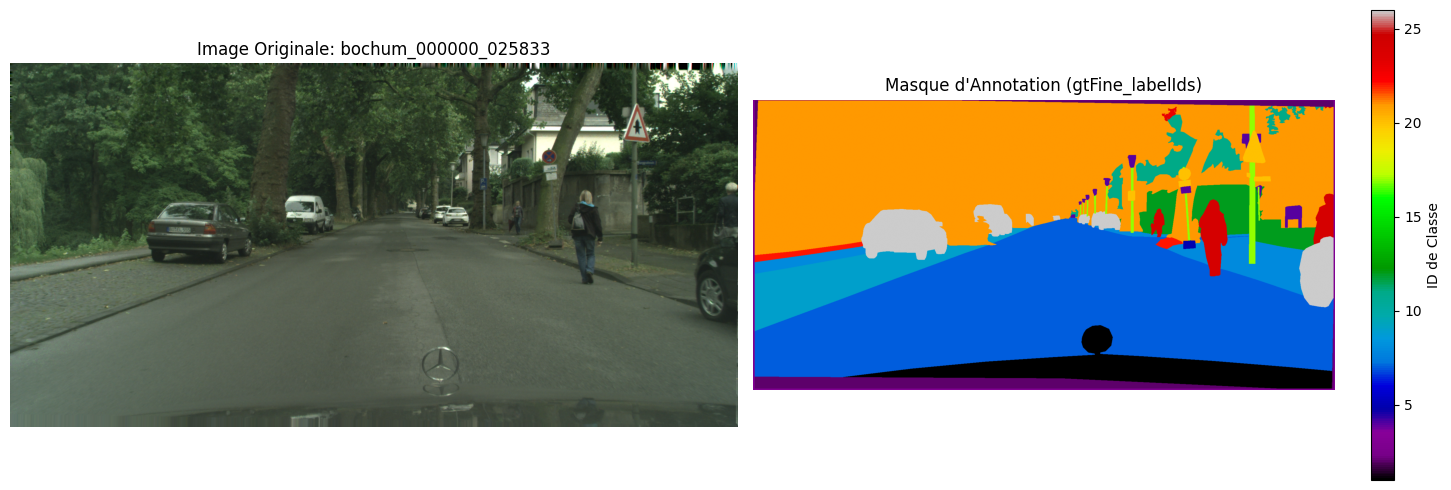

In [4]:
# CELLULE DE VISUALISATION DES IMAGES ET MASQUES

import cv2 # OpenCV pour la lecture et la manipulation d'images
import matplotlib.pyplot as plt # Pour l'affichage des images
import numpy as np # Pour les opérations numériques, notamment sur les tableaux (images)
import os # Pour les opérations sur les chemins de fichiers

# Les variables IMG_TRAIN_DIR, MASK_TRAIN_DIR etc. sont supposées
# être définies par la cellule de configuration des chemins précédente.

try:
    # Vérifier si les dossiers d'entraînement contiennent des données
    if not os.listdir(IMG_TRAIN_DIR_FULL):
        raise FileNotFoundError(f"Le dossier d'images d'entraînement {IMG_TRAIN_DIR_FULL} est vide ou ne contient pas de sous-dossiers de villes.")

    first_city_in_train_img = os.listdir(IMG_TRAIN_DIR_FULL)[0]

    path_to_city_images = os.path.join(IMG_TRAIN_DIR_FULL, first_city_in_train_img)
    if not os.listdir(path_to_city_images):
        raise FileNotFoundError(f"Le dossier de la ville {path_to_city_images} pour les images d'entraînement est vide.")

    # Sélectionner dynamiquement un fichier image exemple
    example_image_file_in_city = os.listdir(path_to_city_images)[0]
    # Extraire le nom de base du fichier (sans extension et suffixe _leftImg8bit)
    example_image_name_base = example_image_file_in_city.replace('_leftImg8bit.png', '')

    # Construire les chemins complets pour l'image et son masque d'annotation
    img_path = os.path.join(IMG_TRAIN_DIR_FULL, first_city_in_train_img, f'{example_image_name_base}_leftImg8bit.png')
    mask_path_labelIds = os.path.join(MASK_TRAIN_DIR_FULL, first_city_in_train_img, f'{example_image_name_base}_gtFine_labelIds.png')

    print(f"Tentative de chargement de l'image : {img_path}")
    print(f"Tentative de chargement du masque (labelIds) : {mask_path_labelIds}")

    # Vérifier l'existence des fichiers avant de tenter de les lire
    if os.path.exists(img_path) and os.path.exists(mask_path_labelIds):
        # Lire l'image avec OpenCV
        img = cv2.imread(img_path)
        # OpenCV lit les images en format BGR (Bleu, Vert, Rouge) par défaut.
        # Matplotlib s'attend à du RGB (Rouge, Vert, Bleu) pour un affichage correct des couleurs.
        # Nous convertissons donc l'ordre des canaux de couleurs.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Lire le masque d'annotation.
        # cv2.IMREAD_UNCHANGED est crucial ici car il assure que le masque est lu
        # tel quel, sans conversion de type ou de nombre de canaux, préservant les ID de classe.
        mask_labelIds = cv2.imread(mask_path_labelIds, cv2.IMREAD_UNCHANGED)

        print(f"\nDimension de l'image : {img.shape}") # Devrait être (hauteur, largeur, 3)
        print(f"Dimension du masque (labelIds) : {mask_labelIds.shape}") # Devrait être (hauteur, largeur)
        print(f"Type de données du masque : {mask_labelIds.dtype}") # Devrait être uint8 pour les ID de classe Cityscapes

        # Analyser les valeurs présentes dans le masque
        unique_ids = np.unique(mask_labelIds)
        print(f"Valeurs min/max dans le masque : {mask_labelIds.min()}/{mask_labelIds.max()}")
        print(f"Valeurs uniques dans le masque labelIds de '{example_image_name_base}': {unique_ids}")
        print(f"Nombre de valeurs uniques : {len(unique_ids)}")

        # Affichage de l'image et du masque
        plt.figure(figsize=(15, 5)) # Taille de la figure pour l'affichage

        plt.subplot(1, 2, 1) # Figure avec 1 ligne, 2 colonnes, ceci est le 1er subplot
        plt.imshow(img)
        plt.title(f'Image Originale: {example_image_name_base}')
        plt.axis('off') # Masquer les axes

        plt.subplot(1, 2, 2) # Ceci est le 2ème subplot
        # 'nipy_spectral' est un colormap qui peut aider à distinguer différentes valeurs numériques.
        # Vous pouvez en essayer d'autres (ex: 'viridis', 'jet', 'tab20').
        plt.imshow(mask_labelIds, cmap='nipy_spectral')
        plt.title(f'Masque d\'Annotation (gtFine_labelIds)')
        plt.colorbar(label='ID de Classe') # Ajoute une légende pour les couleurs/valeurs
        plt.axis('off') # Masquer les axes

        plt.tight_layout() # Ajuste automatiquement les subplots pour un meilleur rendu
        plt.show() # Affiche la figure
    else:
        print("ERREUR : Un des fichiers exemples (image ou masque labelIds) n'a pas été trouvé.")
        if not os.path.exists(img_path): print(f"Image non trouvée à l'emplacement : {img_path}")
        if not os.path.exists(mask_path_labelIds): print(f"Masque labelIds non trouvé à l'emplacement : {mask_path_labelIds}")

except FileNotFoundError as e:
    print(f"ERREUR lors de la recherche de fichiers : {e}")
    print("Veuillez vérifier que les dossiers d'entraînement/validation dans votre sous-ensemble contiennent bien des sous-dossiers de villes, et que ces derniers contiennent des images/masques.")
except IndexError:
    print("ERREUR : Impossible de lister des fichiers dans les dossiers d'images/masques.")
    print("Cela peut se produire si les dossiers de villes sont vides ou si la structure du dataset n'est pas celle attendue.")
except Exception as e:
    print(f"Une erreur inattendue est survenue lors de la visualisation : {e}")

L'exécution de la cellule précédente a permis de charger et visualiser avec succès une image du sous-ensemble Cityscapes et son masque d'annotation `_gtFine_labelIds.png`.

**Observations Clés :**
- **Dimensions Confirmées :** L'image (1024x2048x3) et le masque (1024x2048) ont les dimensions attendues.
- **Type de Données du Masque :** `uint8`, ce qui est correct pour les ID de classe.
- **Contenu du Masque :** Pour l'échantillon visualisé, les ID de classe varient de 0 à 33, avec **16 classes uniques** présentes.

Ces résultats confirment que nous accédons correctement aux données brutes. La présence de multiples ID de classes (jusqu'à 34 possibles au total dans le dataset) dans les masques `_labelIds.png` est la base pour notre tâche de segmentation. La prochaine étape logique impliquerait le mapping de ces classes fines vers les 8 catégories cibles du projet, mais avant cela, nous allons configurer notre outil de suivi d'expériences, MLflow.

### 0.4 Initialisation de MLflow avec Serveur de Tracking Distant via ngrok

Pour suivre et gérer nos expérimentations de modèles de manière robuste et persistante, nous allons maintenant configurer **MLflow**. Au lieu d'utiliser le stockage local temporaire de Colab, nous mettrons en place un **serveur de tracking MLflow accessible à distance** :
1.  Le **serveur MLflow** tournera dans notre environnement Colab.
2.  Ses données (métadonnées et artefacts des expériences) seront stockées de manière **persistante sur Google Drive**.
3.  **ngrok** créera un tunnel public sécurisé vers ce serveur, nous donnant une URL pour accéder à l'interface utilisateur (UI) de MLflow depuis n'importe quel navigateur. Le token d'authentification ngrok (`NGROK_AUTH_TOKEN`) est requis et doit être configuré dans les secrets Colab.

La cellule suivante installe les dépendances nécessaires, lance le serveur MLflow, le connecte à ngrok, et effectue un test de logging pour valider la configuration.

In [5]:
# CELLULE POUR LANCER MLFLOW SERVER AVEC NGROK (VERSION SIMPLIFIÉE)

import mlflow
import os
from google.colab import userdata, drive
import subprocess
import time
from pyngrok import ngrok, conf

# --- 1. Configuration ---
DRIVE_MLFLOW_PARENT_DIR = '/content/drive/MyDrive/Colab Notebooks/OC/P8/mlflow_tracking_persistent' # Adaptez
MLFLOW_BACKEND_STORE_URI = f"sqlite:///{os.path.join(DRIVE_MLFLOW_PARENT_DIR, 'mlflow.db')}"
MLFLOW_DEFAULT_ARTIFACT_ROOT = os.path.join(DRIVE_MLFLOW_PARENT_DIR, 'artifacts')
MLFLOW_PORT = 5000

os.makedirs(os.path.dirname(MLFLOW_BACKEND_STORE_URI.replace("sqlite:///", "")), exist_ok=True)
os.makedirs(MLFLOW_DEFAULT_ARTIFACT_ROOT, exist_ok=True)
print(f"Données MLflow seront stockées dans : {DRIVE_MLFLOW_PARENT_DIR}")

# --- 2. ngrok ---
try:
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
    if not NGROK_AUTH_TOKEN: raise ValueError("Token ngrok (NGROK_AUTH_TOKEN) manquant dans les secrets.")
    conf.get_default().auth_token = NGROK_AUTH_TOKEN
    # Arrêter les tunnels précédents pour éviter les conflits
    try: ngrok.kill()
    except: pass # Ignorer si aucun tunnel n'est actif
    print("Configuration ngrok OK.")
except Exception as e:
    print(f"ERREUR ngrok config : {e}")
    raise

# --- 3. Serveur MLflow ---
# S'assurer d'être dans un répertoire approprié
GIT_REPO_PATH_IN_COLAB = '/content/OC-autonomous-vehicle-segmentation'
if os.path.exists(GIT_REPO_PATH_IN_COLAB): os.chdir(GIT_REPO_PATH_IN_COLAB)
else: os.chdir('/content/')

print(f"Lancement du serveur MLflow depuis {os.getcwd()}...")
# Tuer les instances précédentes
os.system("pkill -f 'mlflow server'")
time.sleep(1)

mlflow_server_command = [
    "mlflow", "server",
    "--backend-store-uri", MLFLOW_BACKEND_STORE_URI,
    "--default-artifact-root", MLFLOW_DEFAULT_ARTIFACT_ROOT,
    "--host", "0.0.0.0", "--port", str(MLFLOW_PORT)
]
# Lance le serveur en arrière-plan, redirige stdout/stderr vers /dev/null pour un output propre
mlflow_server_process = subprocess.Popen(mlflow_server_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
print(f"Serveur MLflow démarré (PID: {mlflow_server_process.pid}). Attente (5s)...")
time.sleep(5) # Laisser le temps de démarrer

if mlflow_server_process.poll() is not None:
    raise RuntimeError("Échec du démarrage du serveur MLflow. Vérifiez la configuration.")
print("Serveur MLflow semble opérationnel.")

# --- 4. Exposer avec ngrok ---
try:
    public_url = ngrok.connect(MLFLOW_PORT, "http").public_url
    print(f"✅ UI MLflow accessible publiquement à : {public_url}")
except Exception as e:
    print(f"ERREUR lancement ngrok tunnel : {e}")
    mlflow_server_process.terminate(); mlflow_server_process.wait() # Tuer le serveur si ngrok échoue
    raise

# --- 5. Configurer et Tester MLflow Client ---
mlflow.set_tracking_uri(f"http://localhost:{MLFLOW_PORT}") # Le client logue vers le serveur local, ngrok fait le pont
print(f"URI de tracking MLflow configurée sur : {mlflow.get_tracking_uri()}")

try:
    with mlflow.start_run(run_name="TestServeurDistantSimplifié"):
        mlflow.log_param("test_param_simple", 123)
        mlflow.log_metric("test_metric_simple", 0.123)
    print(f"🎉 Run de test MLflow ('TestServeurDistantSimplifié') logguée avec succès sur {public_url}")
except Exception as e:
    print(f"ERREUR lors du test de logging MLflow : {e}")

# Conservez la variable `mlflow_server_process` si vous voulez l'arrêter proprement plus tard
# et `public_url` pour la déconnexion ngrok.

Données MLflow seront stockées dans : /content/drive/MyDrive/Colab Notebooks/OC/P8/mlflow_tracking_persistent
Configuration ngrok OK.
Lancement du serveur MLflow depuis /content/OC-autonomous-vehicle-segmentation...
Serveur MLflow démarré (PID: 868). Attente (5s)...
Serveur MLflow semble opérationnel.
✅ UI MLflow accessible publiquement à : https://1569-34-82-252-174.ngrok-free.app
URI de tracking MLflow configurée sur : http://localhost:5000


🏃 View run TestServeurDistantSimplifié at: http://localhost:5000/#/experiments/0/runs/8d5aba9aa1324911a2260ca7d4571c76
🧪 View experiment at: http://localhost:5000/#/experiments/0
🎉 Run de test MLflow ('TestServeurDistantSimplifié') logguée avec succès sur https://1569-34-82-252-174.ngrok-free.app


In [6]:
# Cellule pour arrêter ngrok et le serveur MLflow (exécuter quand vous avez fini)
from pyngrok import ngrok

print("Arrêt des tunnels ngrok...")
try:
    ngrok.kill() # Tue tous les tunnels ngrok de cette session
    print("Tunnels ngrok arrêtés.")
except Exception as e:
    print(f"Erreur lors de l'arrêt de ngrok : {e}")

# Tuer le processus serveur MLflow (si vous avez stocké son PID)
# Si vous n'avez pas le PID, 'pkill' est une option plus brutale mais fonctionne souvent en Colab
print("\nTentative d'arrêt du serveur MLflow...")
os.system("pkill -f 'mlflow server'")
print("Commande pkill pour le serveur MLflow envoyée.")
# Note: mlflow_server_process.terminate() ne fonctionnera que si la variable
# mlflow_server_process de la cellule de démarrage est toujours accessible et que le processus est le même.

Arrêt des tunnels ngrok...
Tunnels ngrok arrêtés.

Tentative d'arrêt du serveur MLflow...
Commande pkill pour le serveur MLflow envoyée.


## 1.0 Préparation du Générateur de Données et Conception des Modèles

### 1.1 Préparation du Générateur de Données

Avec la configuration initiale et l'outil de suivi d'expériences (MLflow) en place, nous entrons maintenant dans la **Phase 1**. L'objectif principal ici est de préparer nos données Cityscapes pour qu'elles puissent être efficacement utilisées par nos modèles de segmentation d'images. Cela implique deux étapes majeures :

1.  **Création d'un Générateur de Données (Data Generator)** : Nous allons développer une classe Python personnalisée, héritant de `tf.keras.utils.Sequence`. Ce générateur sera responsable du chargement des images et des masques, du **mapping des ~34 classes fines de Cityscapes vers nos 8 catégories cibles**, du redimensionnement, de la normalisation, de l'augmentation des données, et de la fourniture des données par lots (batches) au modèle.
2.  **Conception Initiale des Modèles de Segmentation** : Parallèlement, nous définirons les architectures de base pour nos modèles de segmentation (par exemple, un U-Net simple et un U-Net avec un encodeur pré-entraîné), ainsi que les métriques d'évaluation et les fonctions de perte appropriées.

Commençons par la tâche la plus critique : le **développement du générateur de données**, en nous concentrant d'abord sur le chargement des données et le mapping des classes.

#### 1.1.1 Définition du Mapping des Classes : des 34 Classes Cityscapes aux 8 Catégories Cibles

La première étape cruciale dans la préparation de nos données est de traduire les annotations fines fournies par Cityscapes (environ 34 classes distinctes, identifiées par des `id` spécifiques) vers les **8 catégories principales** requises par l'énoncé du projet. Ces 8 catégories sont : `flat`, `human`, `vehicle`, `construction`, `object`, `nature`, `sky`, et `void`.

Pour réaliser ce mapping de manière propre et réutilisable, nous avons :
1.  Créé un fichier Python (`cityscapes_labels.py`) contenant les définitions officielles des labels Cityscapes (nom, `id`, `category`, `ignoreInEval`, etc.). Ce fichier est stocké sur Google Drive et sera versionné avec notre projet.
2.  Importé ces définitions dans notre notebook.
3.  Défini un dictionnaire de correspondance (`category_mapping_to_new_id`) qui associe chaque nom de catégorie Cityscapes pertinent à un nouvel ID cible (de 0 à 7 pour nos 8 catégories).
4.  Généré un dictionnaire final, `id_to_target_id_mapping`, qui mappe chaque `id` original de Cityscapes vers :
    *   L'un de nos nouveaux ID cibles (0-7) si la classe Cityscapes appartient à l'une de nos 8 catégories principales et n'est pas explicitement marquée comme "à ignorer pour l'évaluation" (sauf si sa catégorie est 'void').
    *   Une valeur spéciale (`IGNORE_VALUE_FOR_LOSS = 255`) pour toutes les autres classes (celles à ignorer, celles non pertinentes, ou 'license plate').


In [7]:
# CELLULE POUR DÉFINIR LE MAPPING DES CLASSES (VERSION PROPRE AVEC IMPORT)

import numpy as np
import os
import sys # Pour manipuler le chemin d'importation

# --- Étape 1: Ajouter le chemin du dossier contenant 'cityscapes_labels.py' au sys.path ---
# Ceci est nécessaire pour que Python puisse trouver votre module personnalisé.

# Chemin vers le DOSSIER PARENT de cityscapes_labels.py sur Drive
# Si cityscapes_labels.py est dans '/content/drive/MyDrive/Colab Notebooks/OC/P8/src/cityscapes_labels.py',
# alors le dossier à ajouter à sys.path est '/content/drive/MyDrive/Colab Notebooks/OC/P8/src'

# Supposons que labels_file_path_on_drive de l'étape précédente était:
# labels_file_path_on_drive = '/content/drive/MyDrive/Colab Notebooks/OC/P8/src/cityscapes_labels.py'
# Alors le module_dir est :
module_dir_on_drive = '/content/drive/MyDrive/Colab Notebooks/OC/P8/src' # ADAPTEZ CECI

if module_dir_on_drive not in sys.path:
    sys.path.append(module_dir_on_drive)
    print(f"Ajouté '{module_dir_on_drive}' à sys.path")

# --- Étape 2: Importer la liste 'labels' depuis votre module ---
try:
    from cityscapes_labels import labels as labels_cityscapes # 'labels' est le nom de la variable dans votre .py
    print("Importation de 'labels_cityscapes' depuis 'cityscapes_labels.py' réussie.")
except ImportError as e:
    print(f"ERREUR d'importation : {e}")
    print("Vérifiez que 'cityscapes_labels.py' existe à l'emplacement attendu et que le chemin a été correctement ajouté à sys.path.")
    print(f"Contenu de sys.path: {sys.path}")
    raise # Arrêter ici si l'importation échoue

# --- Étape 3: Définir votre logique de mapping (identique à avant) ---

# Vos 8 catégories cibles et leurs nouveaux IDs (0 à 7)
category_mapping_to_new_id = {
    'flat': 0,
    'human': 1,
    'vehicle': 2,
    'construction': 3,
    'object': 4,
    'nature': 5,
    'sky': 6,
    'void': 7  # Pour 'ground', 'dynamic', 'static' et autres classes de la catégorie 'void' de Cityscapes
}
NUM_TARGET_CLASSES = 8
IGNORE_VALUE_FOR_LOSS = 255 # Valeur pour les pixels non mappés à 0-7 ou explicitement ignorés

# Création du dictionnaire de mapping: cityscapes_id -> new_target_id
id_to_target_id_mapping = {}

for label_info in labels_cityscapes: # Utilise maintenant la variable importée
    cityscapes_id = label_info.id
    cityscapes_category = label_info.category
    ignore_in_eval = label_info.ignoreInEval

    if cityscapes_id == -1: # 'license plate'
        id_to_target_id_mapping[cityscapes_id] = IGNORE_VALUE_FOR_LOSS
        continue

    # Si la classe Cityscapes est marquée 'ignoreInEval=True' ET que sa catégorie N'EST PAS 'void',
    # alors on l'ignore, même si sa catégorie parente est l'une de nos 8.
    if ignore_in_eval and cityscapes_category != 'void':
        id_to_target_id_mapping[cityscapes_id] = IGNORE_VALUE_FOR_LOSS
    # Sinon, si la catégorie de Cityscapes est dans notre mapping direct (flat, human, ..., void)
    elif cityscapes_category in category_mapping_to_new_id:
        id_to_target_id_mapping[cityscapes_id] = category_mapping_to_new_id[cityscapes_category]
    # Pour toutes les autres classes (celles dont la catégorie n'est pas dans notre liste des 8,
    # ou celles explicitement 'unlabeled', 'ego vehicle', etc. qui sont 'void' mais aussi 'ignoreInEval')
    # elles seront implicitement ignorées si leur catégorie n'est pas 'void' et qu'elles sont 'ignoreInEval',
    # ou si leur catégorie n'est simplement pas dans notre mapping des 8.
    # Pour plus de robustesse, on peut ajouter un 'else' pour les mapper à IGNORE_VALUE_FOR_LOSS.
    else:
        # Ce cas devrait attraper les classes comme 'unlabeled', 'ego vehicle', etc.
        # qui sont 'void' et 'ignoreInEval=True', ou toute autre classe non explicitement gérée.
        # Si leur catégorie est 'void', elles sont déjà gérées ci-dessus.
        # Si leur catégorie n'est pas 'void' et pas dans notre mapping, alors ignore.
        # print(f"Info: Classe Cityscapes '{label_info.name}' (ID: {cityscapes_id}, Cat: {cityscapes_category}) non explicitement mappée à 0-7, sera IGNORÉE.")
        id_to_target_id_mapping[cityscapes_id] = IGNORE_VALUE_FOR_LOSS


# Afficher le mapping pour vérification (identique à avant)
print("\n--- Mapping de cityscapes_id vers new_target_id (0-7 pour les 8 catégories, 255 pour ignore) ---")
all_cs_ids = sorted(list(set([lbl.id for lbl in labels_cityscapes]))) # Obtenir tous les ID uniques de Cityscapes

for cs_id in all_cs_ids:
    target_id = id_to_target_id_mapping.get(cs_id, "NON DÉFINI DANS LE MAPPING !") # Utiliser .get pour éviter les erreurs si un ID manque

    original_label_name = "N/A"
    original_category = "N/A"
    ignore_flag = "N/A"
    for lbl in labels_cityscapes:
        if lbl.id == cs_id:
            original_label_name = lbl.name
            original_category = lbl.category
            ignore_flag = lbl.ignoreInEval
            break
    print(f"Cityscapes ID: {cs_id:>2} (Nom: {original_label_name:<22}, Cat: {original_category:<14}, IgnoreEval: {str(ignore_flag):<5})  => Mappé à ID Cible: {target_id}")

# Afficher les ID Cityscapes qui n'ont pas été explicitement mappés (devrait être vide si bien fait)
# Cela aide à s'assurer que tous les ID de 0 à 33 sont couverts.
print("\n--- Vérification des ID Cityscapes non couverts par le mapping (devrait être vide) ---")
mapped_cs_ids = set(id_to_target_id_mapping.keys())
for i in range(34): # ID de 0 à 33
    if i not in mapped_cs_ids:
        print(f"ATTENTION : L'ID Cityscapes {i} n'a pas d'entrée dans id_to_target_id_mapping !")
if -1 not in mapped_cs_ids:
    print(f"ATTENTION : L'ID Cityscapes -1 n'a pas d'entrée dans id_to_target_id_mapping !")

print(f"\nDictionnaire de mapping final ('id_to_target_id_mapping') contient {len(id_to_target_id_mapping)} entrées.")

Ajouté '/content/drive/MyDrive/Colab Notebooks/OC/P8/src' à sys.path
Importation de 'labels_cityscapes' depuis 'cityscapes_labels.py' réussie.

--- Mapping de cityscapes_id vers new_target_id (0-7 pour les 8 catégories, 255 pour ignore) ---
Cityscapes ID: -1 (Nom: license plate         , Cat: vehicle       , IgnoreEval: True )  => Mappé à ID Cible: 255
Cityscapes ID:  0 (Nom: unlabeled             , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  1 (Nom: ego vehicle           , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  2 (Nom: rectification border  , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  3 (Nom: out of roi            , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  4 (Nom: static                , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  5 (Nom: dynamic               , Cat: void          , IgnoreEval: True

Le dictionnaire final contient 35 entrées, couvrant tous les ID Cityscapes de -1 à 33. Ce mapping est maintenant prêt à être utilisé dans notre générateur de données pour transformer les masques d'annotation bruts.

#### 1.1.2 Définition de la Classe Générateur de Données (`CityscapesDataGenerator`)

Nous allons maintenant définir la classe `CityscapesDataGenerator` qui héritera de `tf.keras.utils.Sequence`. Cette classe sera responsable de :
- Charger les paires image/masque.
- Appliquer le `id_to_target_id_mapping` pour convertir les masques vers nos 8 catégories cibles.
- Redimensionner les images et les masques à une taille fixe.
- Normaliser les images.
- (Optionnellement) Appliquer des techniques d'augmentation de données.
- Fournir les données prétraitées par lots (batches) au modèle Keras.

In [8]:
# CELLULE POUR DÉFINIR LA FONCTION UTILITAIRE DE COLLECTE DES CHEMINS DE FICHIERS

def get_cityscapes_filepaths(image_base_dir, mask_base_dir,
                             target_cities=None,
                             image_suffix='_leftImg8bit.png',
                             mask_suffix='_gtFine_labelIds.png'):
    image_paths = []
    mask_paths = []

    if not os.path.isdir(image_base_dir):
        return image_paths, mask_paths
    if not os.path.isdir(mask_base_dir):
        return image_paths, mask_paths

    # Déterminer les villes à parcourir
    available_cities = sorted(os.listdir(image_base_dir))
    cities_to_scan = available_cities
    if target_cities is not None:
        # Filtrer pour ne garder que les target_cities qui existent réellement
        cities_to_scan = [city for city in available_cities if city in target_cities]
        if not cities_to_scan:
            print(f"AVERTISSEMENT : Aucune des villes cibles {target_cities} n'a été trouvée dans {image_base_dir}.")
            return image_paths, mask_paths
        print(f"Scan limité aux villes cibles : {cities_to_scan}")


    for city_folder_name in cities_to_scan: # Utilise maintenant la liste filtrée ou complète
        city_image_dir_abs = os.path.join(image_base_dir, city_folder_name)
        city_mask_dir_abs = os.path.join(mask_base_dir, city_folder_name)

        if os.path.isdir(city_image_dir_abs) and os.path.isdir(city_mask_dir_abs):
            for img_file_name in sorted(os.listdir(city_image_dir_abs)):
                if img_file_name.endswith(image_suffix):
                    base_name = img_file_name.replace(image_suffix, '')
                    full_img_path = os.path.join(city_image_dir_abs, img_file_name)
                    mask_file_name_expected = f"{base_name}{mask_suffix}"
                    full_mask_path_expected = os.path.join(city_mask_dir_abs, mask_file_name_expected)

                    if os.path.isfile(full_mask_path_expected):
                        image_paths.append(full_img_path)
                        mask_paths.append(full_mask_path_expected)

    if not image_paths:
        print(f"Aucune paire image/masque trouvée. Vérifiez les chemins de base et la structure des dossiers:\n"
              f"  Dossier Images: {image_base_dir}\n"
              f"  Dossier Masques: {mask_base_dir}\n"
              f"  Suffixe Image Attendu: {image_suffix}\n"
              f"  Suffixe Masque Attendu: {mask_suffix}")

    return image_paths, mask_paths

# --- TEST DE LA FONCTION UTILITAIRE ---
# Assurez-vous que les variables globales IMG_TRAIN_DIR, MASK_TRAIN_DIR, IMG_VAL_DIR, MASK_VAL_DIR
# sont bien définies et pointent vers les bons dossiers de votre sous-ensemble sur Drive.

print("--- Test de get_cityscapes_filepaths pour l'ensemble d'entraînement ---")
# Ces variables (IMG_TRAIN_DIR, etc.) doivent être définies par votre cellule de configuration des chemins de données
if 'IMG_TRAIN_DIR_FULL' in globals() and 'MASK_TRAIN_DIR_FULL' in globals():
    train_image_fnames, train_mask_fnames = get_cityscapes_filepaths(IMG_TRAIN_DIR_FULL, MASK_TRAIN_DIR_FULL)
    print(f"Trouvé {len(train_image_fnames)} images et {len(train_mask_fnames)} masques pour l'entraînement.")
    if train_image_fnames: # Afficher les premiers pour vérification
        print("Exemples de chemins d'images d'entraînement:")
        for p in train_image_fnames[:3]: print(f"  {p}")
        print("Exemples de chemins de masques d'entraînement:")
        for p in train_mask_fnames[:3]: print(f"  {p}")
else:
    print("Variables IMG_TRAIN_DIR ou MASK_TRAIN_DIR non définies. Test sauté.")

print("\n--- Test de get_cityscapes_filepaths pour l'ensemble de validation ---")
if 'IMG_VAL_DIR_FULL' in globals() and 'MASK_VAL_DIR_FULL' in globals():
    val_image_fnames, val_mask_fnames = get_cityscapes_filepaths(IMG_VAL_DIR_FULL, MASK_VAL_DIR_FULL)
    print(f"Trouvé {len(val_image_fnames)} images et {len(val_mask_fnames)} masques pour la validation.")
    if val_image_fnames: # Afficher les premiers pour vérification
        print("Exemples de chemins d'images de validation:")
        for p in val_image_fnames[:3]: print(f"  {p}")
        print("Exemples de chemins de masques de validation:")
        for p in val_mask_fnames[:3]: print(f"  {p}")
else:
    print("Variables IMG_VAL_DIR ou MASK_VAL_DIR non définies. Test sauté.")

--- Test de get_cityscapes_filepaths pour l'ensemble d'entraînement ---
Trouvé 2975 images et 2975 masques pour l'entraînement.
Exemples de chemins d'images d'entraînement:
  /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png
  /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000001_000019_leftImg8bit.png
  /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000002_000019_leftImg8bit.png
Exemples de chemins de masques d'entraînement:
  /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png
  /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000001_000019_gtFine_labelIds.png
  /content/drive/MyDrive/Co

In [9]:
!pip install albumentations -q

In [10]:
# CELLULE COMPLÈTE ET MISE À JOUR POUR LA CLASSE CityscapesDataGenerator

import tensorflow as tf
import numpy as np
import cv2
import os
import math

# Les variables globales comme id_to_target_id_mapping, NUM_TARGET_CLASSES, IGNORE_VALUE_FOR_LOSS
# sont supposées être définies dans des cellules précédentes de votre notebook.

class CityscapesDataGenerator(tf.keras.utils.Sequence):
    """
    Générateur de données pour le dataset Cityscapes, adapté pour la segmentation sémantique.
    Prend des listes de chemins de fichiers images et masques en entrée.
    """
    def __init__(self,
                 image_filenames_list,    # Nouvelle entrée : liste des chemins d'images
                 mask_filenames_list,     # Nouvelle entrée : liste des chemins de masques
                 id_to_target_mapping,    # Dictionnaire de mapping des classes
                 batch_size,              # Taille du batch
                 target_img_size,         # Tuple (hauteur, largeur) cible
                 num_target_classes,      # Nombre de classes cibles (ex: 8)
                 ignore_value,            # Valeur pour les pixels ignorés
                 shuffle=True,            # Mélanger les données à chaque epoch ?
                 augmentations=None):     # Pipeline d'augmentation Albumentations (optionnel)
        """
        Constructeur de la classe CityscapesDataGenerator.
        """
        # Assertions pour vérifier la validité des listes de fichiers fournies
        assert len(image_filenames_list) == len(mask_filenames_list), \
            "Le nombre d'images et de masques dans les listes fournies doit être identique."
        assert len(image_filenames_list) > 0, \
            "La liste des fichiers images ne peut pas être vide."

        self.image_filenames = image_filenames_list
        self.mask_filenames = mask_filenames_list
        self.id_to_target_mapping = id_to_target_mapping
        self.batch_size = batch_size
        self.target_img_size = target_img_size # ex: (256, 512)
        self.num_target_classes = num_target_classes
        self.ignore_value = ignore_value
        self.shuffle = shuffle
        self.augmentations = augmentations

        # Index pour le shuffle et l'accès aux batches
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle:
            self.on_epoch_end() # Mélanger initialement

        print(f"Générateur initialisé avec {len(self.image_filenames)} paires image/masque fournies.")
        if len(self.image_filenames) < self.batch_size:
            print(f"AVERTISSEMENT : Nombre d'échantillons ({len(self.image_filenames)}) "
                  f"est inférieur à batch_size ({self.batch_size}).")

    def __len__(self):
        """
        Retourne le nombre de batches par epoch.
        """
        if len(self.image_filenames) == 0:
            return 0
        return math.ceil(len(self.image_filenames) / self.batch_size)

    def __getitem__(self, index):
        """
        Génère un batch de données (images et masques).
        'index' est l'index du batch.
        """
        # Déterminer les indexes des échantillons pour ce batch
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Récupérer les noms de fichiers pour ces indexes
        batch_image_filenames = [self.image_filenames[i] for i in batch_indexes]
        batch_mask_filenames = [self.mask_filenames[i] for i in batch_indexes]

        # Initialiser les tableaux pour le batch
        X_batch = np.zeros((len(batch_image_filenames), self.target_img_size[0], self.target_img_size[1], 3), dtype=np.float32)
        y_batch = np.full((len(batch_mask_filenames), self.target_img_size[0], self.target_img_size[1]),
                          fill_value=self.ignore_value, dtype=np.uint8)

        for i, (img_path, mask_path) in enumerate(zip(batch_image_filenames, batch_mask_filenames)):
            try:
                # Charger l'image
                img = cv2.imread(img_path)
                if img is None:
                    # print(f"AVERTISSEMENT : Impossible de charger l'image {img_path}. Item ignoré.")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Charger le masque brut
                mask_raw = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
                if mask_raw is None:
                    # print(f"AVERTISSEMENT : Impossible de charger le masque {mask_path}. Item ignoré.")
                    continue

                # Appliquer le mapping des classes
                mapped_mask = self._apply_class_mapping(mask_raw)

                # Conserver l'image et le masque actuels pour l'augmentation/redimensionnement
                current_img = img
                current_mask = mapped_mask

                # Appliquer les augmentations (si définies)
                if self.augmentations:
                    augmented = self.augmentations(image=current_img, mask=current_mask)
                    current_img = augmented['image']
                    current_mask = augmented['mask']

                # Redimensionner à la taille cible
                target_dsize = (self.target_img_size[1], self.target_img_size[0]) # (largeur, hauteur) pour cv2.resize

                img_final = cv2.resize(current_img, target_dsize, interpolation=cv2.INTER_LINEAR)
                mask_final = cv2.resize(current_mask, target_dsize, interpolation=cv2.INTER_NEAREST)

                # Normaliser l'image et assigner au batch
                X_batch[i] = img_final / 255.0
                y_batch[i] = mask_final

            except Exception as e:
                print(f"ERREUR lors du traitement de l'item {i} (img: {img_path}, mask: {mask_path}): {e}")
                # X_batch[i] et y_batch[i] conserveront leurs valeurs d'initialisation (zéros/ignore_value)
                # ce qui est généralement acceptable, mais peut introduire des échantillons "vides" si fréquent.
                continue # Passer à l'item suivant du batch

        return X_batch, y_batch

    def on_epoch_end(self):
        """
        Appelé à la fin de chaque epoch. Utilisé ici pour mélanger les indexes si self.shuffle est True.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _apply_class_mapping(self, mask_raw):
        """
        Applique le mapping des ID de classes Cityscapes aux ID de classes cibles.
        """
        mapped_mask = np.full(mask_raw.shape, self.ignore_value, dtype=np.uint8)
        for cityscapes_id, target_id in self.id_to_target_mapping.items():
            # L'ID -1 (license plate) est déjà mappé à ignore_value dans le dictionnaire,
            # donc il sera correctement géré.
            mapped_mask[mask_raw == cityscapes_id] = target_id
        return mapped_mask

#### 1.1.3 Instanciation des Générateurs de Données pour le Développement

Maintenant que la classe `CityscapesDataGenerator` est définie et que nous disposons de la fonction utilitaire `get_cityscapes_filepaths` pour collecter les chemins de fichiers, nous pouvons créer les instances de nos générateurs.

Pour la phase de développement et de prototypage rapide, nous allons travailler avec un **échantillon de villes** sélectionnées à partir des ensembles de données `train`, `val`, et `test` complets. La cellule suivante va :
1.  Définir les listes de villes cibles pour nos ensembles de développement (`DEV_TRAIN_CITIES`, `DEV_VAL_CITIES`, `DEV_TEST_CITIES`).
2.  Utiliser `get_cityscapes_filepaths` pour collecter les listes de fichiers images et masques correspondants à ces villes.
3.  Définir un pipeline d'augmentation de données (`aug_pipeline_train_dev`) qui sera appliqué uniquement au générateur d'entraînement.
4.  Instancier trois objets `CityscapesDataGenerator` :
    *   `train_generator_dev` : Pour l'entraînement, avec augmentation et mélange des données.
    *   `val_generator_dev` : Pour la validation, sans augmentation ni mélange.
    *   `test_generator_dev` : Pour le test, sans augmentation ni mélange.
5.  Effectuer un test rapide pour récupérer un batch du `train_generator_dev` et visualiser un échantillon afin de vérifier que tout fonctionne comme attendu (y compris les augmentations).

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


--- Collecte des fichiers pour l'ÉCHANTILLON DE DÉVELOPPEMENT ---
Scan limité aux villes cibles : ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt']
Scan limité aux villes cibles : ['frankfurt']
Scan limité aux villes cibles : ['munich']
Dev Train: 825 imgs des villes ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt']
Dev Val: 267 imgs des villes ['frankfurt']
Dev Test: 398 imgs des villes ['munich']
Pipeline d'augmentation défini.

--- Instanciation des générateurs de DÉVELOPPEMENT ---
Générateur initialisé avec 825 paires image/masque fournies.
train_generator_dev (avec augmentation) créé avec 207 batches.
Générateur initialisé avec 267 paires image/masque fournies.
val_generator_dev (sans augmentation) créé avec 67 batches.
Générateur initialisé avec 398 paires image/masque fournies.
test_generator_dev (sans augmentation) créé avec 100 batches.

Test de récupération d'un batch depuis train_generator_dev (avec augmentation):
  Shape X_dev_batch: (4, 256, 512, 3)
  Shape y_dev

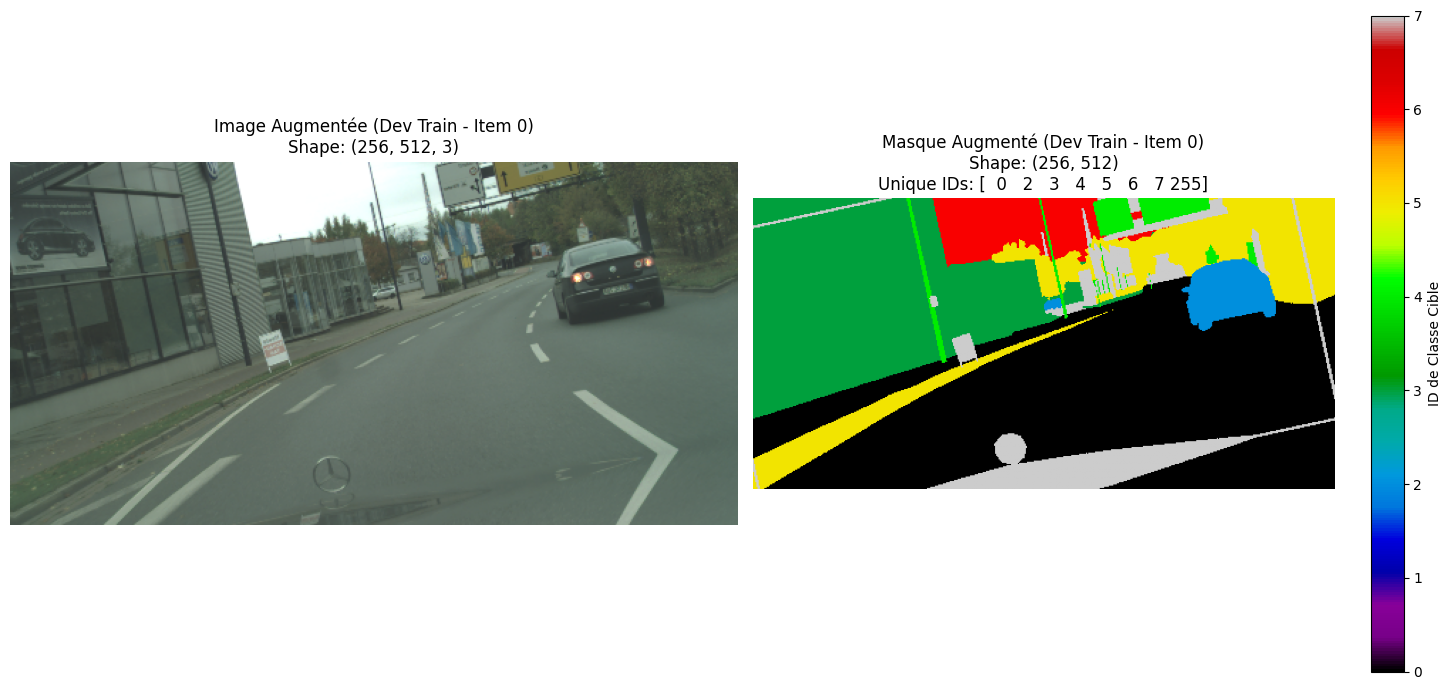

In [11]:
# CELLULE COMBINÉE POUR COLLECTE DE FICHIERS, DÉFINITION AUGMENTATION, ET INSTANCIATION DES GÉNÉRATEURS DE DEV

import os
import albumentations as A
import cv2
import numpy as np # Pour le test de batch
import matplotlib.pyplot as plt # Pour la visualisation

# --- Assurez-vous que ces variables globales sont définies par des cellules précédentes ---
# IMG_TRAIN_DIR_FULL, MASK_TRAIN_DIR_FULL, IMG_VAL_DIR_FULL, MASK_VAL_DIR_FULL, IMG_TEST_DIR_FULL, MASK_TEST_DIR_FULL
# id_to_target_id_mapping, NUM_TARGET_CLASSES, IGNORE_VALUE_FOR_LOSS
# La fonction get_cityscapes_filepaths doit aussi être définie.

# --- Définition des Villes pour l'Échantillon de Développement ---
# Remplacez par des noms de villes réels de vos splits
DEV_TRAIN_CITIES = ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt'] # Exemple, utilisez une ou deux villes de votre ensemble train complet
DEV_VAL_CITIES = ['frankfurt']    # Exemple, une ville de votre val complet
DEV_TEST_CITIES = ['munich']     # Exemple, une ville de votre test complet

print("--- Collecte des fichiers pour l'ÉCHANTILLON DE DÉVELOPPEMENT ---")
img_fnames_train_dev, mask_fnames_train_dev = get_cityscapes_filepaths(
    IMG_TRAIN_DIR_FULL, MASK_TRAIN_DIR_FULL, target_cities=DEV_TRAIN_CITIES
)
img_fnames_val_dev, mask_fnames_val_dev = get_cityscapes_filepaths(
    IMG_VAL_DIR_FULL, MASK_VAL_DIR_FULL, target_cities=DEV_VAL_CITIES
)
img_fnames_test_dev, mask_fnames_test_dev = get_cityscapes_filepaths(
    IMG_TEST_DIR_FULL, MASK_TEST_DIR_FULL, target_cities=DEV_TEST_CITIES
)
print(f"Dev Train: {len(img_fnames_train_dev)} imgs des villes {DEV_TRAIN_CITIES}")
print(f"Dev Val: {len(img_fnames_val_dev)} imgs des villes {DEV_VAL_CITIES}")
print(f"Dev Test: {len(img_fnames_test_dev)} imgs des villes {DEV_TEST_CITIES}")

# --- Paramètres pour les Générateurs de Développement ---
BATCH_SIZE_DEV = 4
TARGET_IMG_HEIGHT_DEV = 256
TARGET_IMG_WIDTH_DEV = 512

# --- Définition du Pipeline d'Augmentation ---
aug_pipeline_train_dev = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine( # Remplacement de ShiftScaleRotate
        scale=(0.9, 1.1), # Correspond à scale_limit=0.1
        translate_percent={"x": (-0.0625, 0.0625), "y": (-0.0625, 0.0625)}, # Correspond à shift_limit=0.0625
        rotate=(-15, 15), # Correspond à rotate_limit=15
        p=0.7,
        interpolation=cv2.INTER_LINEAR,       # Pour l'image
        mask_interpolation=cv2.INTER_NEAREST, # Pour le masque (souvent le défaut pour les masques)
        border_mode=cv2.BORDER_REFLECT_101, # Alternative plus sûre pour les masques
                                            # ou cv2.BORDER_REPLICATE
    ),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(std_range=(10/255, 50/255), p=0.3)
])
print("Pipeline d'augmentation défini.")

# --- Instanciation des générateurs de DÉVELOPPEMENT ---
print("\n--- Instanciation des générateurs de DÉVELOPPEMENT ---")

train_generator_dev = None
if img_fnames_train_dev:
    train_generator_dev = CityscapesDataGenerator(
        image_filenames_list=img_fnames_train_dev, mask_filenames_list=mask_fnames_train_dev,
        id_to_target_mapping=id_to_target_id_mapping, batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES, ignore_value=IGNORE_VALUE_FOR_LOSS,
        shuffle=True, augmentations=aug_pipeline_train_dev
    )
    print(f"train_generator_dev (avec augmentation) créé avec {len(train_generator_dev)} batches.")
else:
    print("Aucun fichier pour train_generator_dev. Générateur non créé.")

val_generator_dev = None
if img_fnames_val_dev:
    val_generator_dev = CityscapesDataGenerator(
        image_filenames_list=img_fnames_val_dev, mask_filenames_list=mask_fnames_val_dev,
        id_to_target_mapping=id_to_target_id_mapping, batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES, ignore_value=IGNORE_VALUE_FOR_LOSS,
        shuffle=False, augmentations=None
    )
    print(f"val_generator_dev (sans augmentation) créé avec {len(val_generator_dev)} batches.")
else:
    print("Aucun fichier pour val_generator_dev. Générateur non créé.")

test_generator_dev = None
if img_fnames_test_dev:
    test_generator_dev = CityscapesDataGenerator(
        image_filenames_list=img_fnames_test_dev, mask_filenames_list=mask_fnames_test_dev,
        id_to_target_mapping=id_to_target_id_mapping, batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES, ignore_value=IGNORE_VALUE_FOR_LOSS,
        shuffle=False, augmentations=None
    )
    print(f"test_generator_dev (sans augmentation) créé avec {len(test_generator_dev)} batches.")
else:
    print("Aucun fichier pour test_generator_dev. Générateur non créé.")

# --- Test rapide d'un batch du générateur d'entraînement (AVEC augmentation) ---
if train_generator_dev and len(train_generator_dev) > 0:
    print("\nTest de récupération d'un batch depuis train_generator_dev (avec augmentation):")
    X_dev_batch, y_dev_batch = train_generator_dev[0]
    print(f"  Shape X_dev_batch: {X_dev_batch.shape}")
    print(f"  Shape y_dev_batch: {y_dev_batch.shape}")
    print(f"  Valeurs uniques dans le premier masque de y_dev_batch: {np.unique(y_dev_batch[0])}")

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(X_dev_batch[0])
    plt.title(f'Image Augmentée (Dev Train - Item 0)\nShape: {X_dev_batch[0].shape}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    unique_mask_values_dev = np.unique(y_dev_batch[0])
    active_classes_present_dev = unique_mask_values_dev[unique_mask_values_dev != IGNORE_VALUE_FOR_LOSS]
    v_max_val_dev = NUM_TARGET_CLASSES - 1 # Default vmax
    if len(active_classes_present_dev) > 0:
        v_max_val_dev = max(NUM_TARGET_CLASSES - 1, np.max(active_classes_present_dev))

    plt.imshow(y_dev_batch[0], cmap='nipy_spectral', vmin=0, vmax=v_max_val_dev)
    plt.title(f'Masque Augmenté (Dev Train - Item 0)\nShape: {y_dev_batch[0].shape}\nUnique IDs: {unique_mask_values_dev}')
    plt.colorbar(label='ID de Classe Cible')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("\nImpossible de tester train_generator_dev (non créé ou vide).")

##### Analyse de la Visualisation du Batch Augmenté

La visualisation ci-dessus montre un exemple d'image et de son masque correspondant après application du pipeline d'augmentation, du mapping de classes, et du redimensionnement. On peut observer un effet de rotation ainsi qu'une réduction de la luminosité. Les ID de classes dans le masque sont conformes à nos 8 catégories cibles.

Notre générateur de données est maintenant capable de fournir des données brutes ou augmentées, prêtes pour l'entraînement de modèles.

### 1.2 : Définition des Métriques d'Évaluation et Fonctions de Perte Personnalisées

Avant de construire nos modèles de segmentation, il est essentiel de définir comment nous allons mesurer leur performance et comment nous allons les guider pendant l'entraînement. Pour cela, nous allons implémenter :

1.  **Métriques d'Évaluation :**
    *   **Mean Intersection over Union (mIoU) :** Une métrique standard pour la segmentation, disponible dans `tf.keras.metrics`.
    *   **Dice Coefficient :** Une autre métrique clé, particulièrement utile pour les classes déséquilibrées. Nous allons créer une fonction personnalisée pour la calculer et la suivre pendant l'entraînement.

2.  **Fonctions de Perte (Loss Functions) :**
    *   **Sparse Categorical Cross-Entropy :** Une perte de base pour la classification par pixel, disponible dans `tf.keras.losses`.
    *   **Dice Loss :** Dérivée du Dice Coefficient (`1 - Dice`), elle vise à maximiser directement le chevauchement spatial. Nous créerons une fonction de perte personnalisée pour celle-ci.
    *   **Perte Combinée :** Une combinaison pondérée de la Sparse Categorical Cross-Entropy et de la Dice Loss, pour bénéficier des avantages des deux.

La cellule suivante définira les fonctions nécessaires pour notre métrique Dice Coefficient personnalisée et pour la Dice Loss.

In [12]:
# CELLULE POUR DÉFINIR LES MÉTRIQUES ET PERTES PERSONNALISÉES

import tensorflow as tf
import keras.backend as K # Keras backend pour des opérations bas niveau sur les tenseurs

# --- Métrique : Dice Coefficient ---
# NUM_TARGET_CLASSES et IGNORE_VALUE_FOR_LOSS doivent être définis globalement
# NUM_TARGET_CLASSES = 8 (nos classes 0-7)
# IGNORE_VALUE_FOR_LOSS = 255

def dice_coefficient_metric(y_true, y_pred, smooth=1e-6):
    """
    Calcule le Dice Coefficient comme métrique pour la segmentation multi-classes.
    Args:
        y_true: Tenseur des masques de vérité terrain.
                Shape: (batch_size, height, width). Contient des ID de classe entiers (0 à NUM_TARGET_CLASSES-1).
                Les pixels avec IGNORE_VALUE_FOR_LOSS sont ignorés.
        y_pred: Tenseur des prédictions du modèle (logits bruts ou probabilités après softmax).
                Shape: (batch_size, height, width, NUM_TARGET_CLASSES).
        smooth (float): Petite constante pour éviter la division par zéro.
    Returns:
        tf.Tensor: Score Dice moyen sur les classes (hors pixels ignorés).
    """
    # 1. Prétraiter y_true:
    #    - S'assurer qu'il est de type entier pour tf.one_hot
    #    - Créer un masque pour les pixels à ne pas ignorer
    y_true_int = tf.cast(y_true, tf.int32)

    # Créer un masque pour les pixels valides (ceux qui ne sont pas IGNORE_VALUE_FOR_LOSS)
    # y_true_reshaped aura la forme (batch_size, height, width)
    valid_pixels_mask = tf.not_equal(y_true_int, IGNORE_VALUE_FOR_LOSS) # True où y_true n'est pas 255

    # Convertir y_true en one-hot uniquement pour les pixels valides, et pour les classes 0 à NUM_TARGET_CLASSES-1
    # Les pixels avec IGNORE_VALUE_FOR_LOSS auront un vecteur one-hot de zéros, ce qui est bien.
    y_true_one_hot = tf.one_hot(y_true_int, depth=NUM_TARGET_CLASSES, axis=-1, dtype=tf.float32)
    # y_true_one_hot aura la forme (batch_size, height, width, NUM_TARGET_CLASSES)

    # 2. Prétraiter y_pred:
    #    - Appliquer softmax si ce ne sont pas déjà des probabilités (généralement déjà fait par le modèle)
    #    - Pas besoin de l'argmax ici car le Dice est souvent calculé sur les probabilités.
    y_pred_probs = tf.nn.softmax(y_pred, axis=-1) # Assure que ce sont des probabilités

    # 3. Calculer le Dice par classe, puis moyenner (en ignorant les pixels non valides)
    # Aplatir les dimensions spatiales pour faciliter le calcul
    # Nouvelles formes : (batch_size * height * width, NUM_TARGET_CLASSES)
    y_true_flat = tf.reshape(y_true_one_hot, [-1, NUM_TARGET_CLASSES])
    y_pred_flat = tf.reshape(y_pred_probs, [-1, NUM_TARGET_CLASSES])
    valid_pixels_mask_flat = tf.reshape(valid_pixels_mask, [-1]) # (batch_size * height * width)

    # Filtrer les pixels non valides (ceux où y_true était IGNORE_VALUE_FOR_LOSS)
    y_true_filtered = tf.boolean_mask(y_true_flat, valid_pixels_mask_flat)
    y_pred_filtered = tf.boolean_mask(y_pred_flat, valid_pixels_mask_flat)

    # S'il ne reste aucun pixel valide après filtrage (cas rare, ex: masque entièrement ignoré)
    if tf.size(y_true_filtered) == 0:
        return tf.constant(0.0, dtype=tf.float32) # Ou 1.0 si on considère qu'il n'y a rien à mal prédire

    # Intersection : somme sur les pixels du produit y_true * y_pred pour chaque classe
    intersection = tf.reduce_sum(y_true_filtered * y_pred_filtered, axis=0) # Shape: (NUM_TARGET_CLASSES,)

    # Somme des carrés (ou des valeurs absolues) pour le dénominateur
    # Dice utilise la somme simple des probabilités/valeurs one-hot
    sum_y_true = tf.reduce_sum(y_true_filtered, axis=0) # Shape: (NUM_TARGET_CLASSES,)
    sum_y_pred = tf.reduce_sum(y_pred_filtered, axis=0) # Shape: (NUM_TARGET_CLASSES,)

    dice_per_class = (2. * intersection + smooth) / (sum_y_true + sum_y_pred + smooth) # Shape: (NUM_TARGET_CLASSES,)

    # Mean Dice sur les classes.
    # Important: certaines classes pourraient ne pas être présentes dans y_true_filtered (leur sum_y_true serait 0).
    # On ne moyenne que sur les classes qui ont un sens (celles présentes ou prédites).
    # Ou plus simplement, on moyenne sur toutes nos NUM_TARGET_CLASSES.
    # Si une classe n'a aucun pixel dans y_true_filtered, son dice_per_class sera proche de 0 si elle est prédite,
    # ou proche de 1 (à cause de smooth/smooth) si elle n'est ni dans y_true ni dans y_pred.
    # C'est un point délicat du Mean Dice.
    # Une approche est de ne moyenner que sur les classes présentes dans le batch (si sum_y_true > 0).
    # Pour une métrique Keras, une moyenne simple sur les NUM_TARGET_CLASSES est souvent faite.

    # On peut choisir de ne pas inclure la classe "void" (ID 7) dans la moyenne si elle est juste un fourre-tout.
    # Supposons que NUM_TARGET_CLASSES inclut la classe void et que nous voulons la moyenner.
    mean_dice = tf.reduce_mean(dice_per_class)

    return mean_dice

#### 1.2.1 Implémentation de la Dice Loss

La **Dice Loss** est directement dérivée du Dice Coefficient. L'objectif étant de maximiser le Dice Coefficient (qui mesure la similarité, variant de 0 à 1), la perte est souvent définie comme `1 - DiceCoefficient`. En minimisant cette perte, nous maximisons le Dice Coefficient.

Cette fonction de perte est particulièrement efficace pour gérer le déséquilibre des classes dans les tâches de segmentation, car elle se concentre sur le chevauchement des régions plutôt que sur la classification correcte de chaque pixel individuellement (comme le ferait la Cross-Entropy).

La cellule suivante définit une fonction pour la Dice Loss, qui pourra être utilisée lors de la compilation de nos modèles Keras. Elle réutilisera une partie de la logique de calcul du Dice Coefficient que nous avons vue pour la métrique, mais adaptée pour fonctionner comme une fonction de perte (par exemple, en opérant sur les probabilités prédites et les cibles one-hot).

In [13]:
# CELLULE POUR DÉFINIR LES MÉTRIQUES ET PERTES PERSONNALISÉES (SUITE)

# (La fonction dice_coefficient_metric est définie dans la cellule précédente ou plus haut)
# NUM_TARGET_CLASSES et IGNORE_VALUE_FOR_LOSS doivent être définis globalement

# --- Fonction de Perte : Dice Loss ---
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Calcule la Dice Loss pour la segmentation multi-classes.
    Loss = 1 - Mean Dice Coefficient (calculé sur les pixels valides).

    Args:
        y_true: Tenseur des masques de vérité terrain.
                Shape: (batch_size, height, width). Contient des ID de classe entiers (0 à NUM_TARGET_CLASSES-1).
                Les pixels avec IGNORE_VALUE_FOR_LOSS (ex: 255) sont ignorés.
        y_pred: Tenseur des prédictions du modèle (logits bruts ou probabilités après softmax).
                Shape: (batch_size, height, width, NUM_TARGET_CLASSES).
        smooth (float): Petite constante pour éviter la division par zéro et lisser.
    Returns:
        tf.Tensor: Valeur de la Dice Loss (scalaire).
    """
    # 1. Prétraiter y_true (identique à la métrique Dice):
    y_true_int = tf.cast(y_true, tf.int32)
    valid_pixels_mask = tf.not_equal(y_true_int, IGNORE_VALUE_FOR_LOSS)
    y_true_one_hot = tf.one_hot(y_true_int, depth=NUM_TARGET_CLASSES, axis=-1, dtype=tf.float32)

    # 2. Prétraiter y_pred (identique à la métrique Dice):
    # Il est crucial que y_pred soit des probabilités (sortie de softmax) pour la Dice Loss.
    # Si votre modèle sort des logits, la fonction de perte Keras doit avoir from_logits=True
    # ou vous appliquez softmax ici. Pour une fonction de perte personnalisée, c'est plus sûr
    # de s'attendre à des probabilités.
    y_pred_probs = tf.nn.softmax(y_pred, axis=-1)

    # 3. Aplatir et Filtrer (identique à la métrique Dice):
    y_true_flat = tf.reshape(y_true_one_hot, [-1, NUM_TARGET_CLASSES])
    y_pred_flat = tf.reshape(y_pred_probs, [-1, NUM_TARGET_CLASSES])
    valid_pixels_mask_flat = tf.reshape(valid_pixels_mask, [-1])

    y_true_filtered = tf.boolean_mask(y_true_flat, valid_pixels_mask_flat)
    y_pred_filtered = tf.boolean_mask(y_pred_flat, valid_pixels_mask_flat)

    # S'il ne reste aucun pixel valide après filtrage
    if tf.size(y_true_filtered) == 0:
        # Considérons le cas où il n'y a AUCUN pixel à évaluer : on peut dire que la perte est 0.
        return tf.constant(0.0, dtype=tf.float32)


    # 4. Calcul du Dice Coefficient (par classe, puis moyenne - identique à la métrique Dice):
    intersection = tf.reduce_sum(y_true_filtered * y_pred_filtered, axis=0)
    sum_y_true = tf.reduce_sum(y_true_filtered, axis=0)
    sum_y_pred = tf.reduce_sum(y_pred_filtered, axis=0)

    dice_per_class = (2. * intersection + smooth) / (sum_y_true + sum_y_pred + smooth)

    # Mean Dice sur les classes.
    # Pour la Dice Loss, il est courant de moyenner les coefficients Dice des classes
    # puis de faire 1 - cette moyenne.
    # Alternativement, on peut faire la moyenne des (1 - Dice_classe_i).
    # La première approche est plus standard.
    mean_dice_coeff = tf.reduce_mean(dice_per_class)

    # 5. Calculer la Perte
    loss = 1.0 - mean_dice_coeff

    return loss

#### 1.2.2 Définition de la Fonction de Perte Combinée

Pour bénéficier à la fois de la stabilité de l'entropie croisée et de la capacité de la Dice Loss à gérer le déséquilibre des classes et à optimiser directement le chevauchement spatial, nous allons définir une fonction de perte combinée.

Cette perte sera une somme pondérée de la `SparseCategoricalCrossentropy` et de notre `dice_loss` personnalisée :

`Loss_Total = α * Loss_SparseCE + β * Loss_Dice`

Les coefficients `α` (alpha) et `β` (beta) permettent d'ajuster l'importance relative de chaque composante de la perte. Un choix courant est de les mettre à `0.5` chacun, mais ils peuvent être considérés comme des hyperparamètres à optimiser.

La cellule suivante définit cette fonction de perte combinée.

In [14]:
# CELLULE POUR DÉFINIR LES MÉTRIQUES ET PERTES PERSONNALISÉES (SUITE)

# (Les fonctions dice_coefficient_metric et dice_loss sont définies plus haut)
# (tf, K, np, os, math, etc. sont supposés importés)
# (NUM_TARGET_CLASSES et IGNORE_VALUE_FOR_LOSS sont supposés définis globalement)

# --- Création d'une instance de la perte combinée ---
class CombinedDiceSparseCELoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5, beta=0.5, smooth_dice=1e-6, name="combined_dice_sparse_ce_loss"):
        super().__init__(name=name)
        self.alpha = alpha
        self.beta = beta
        self.smooth_dice = smooth_dice
        self.sparse_ce_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False,
            reduction=tf.keras.losses.Reduction.NONE # Important pour appliquer sample_weight correctement
        )

    def call(self, y_true, y_pred):
        y_true_int = tf.cast(y_true, tf.int32)

        # Poids pour SparseCE (ignorer les pixels avec IGNORE_VALUE_FOR_LOSS)
        # sample_weights aura la forme (batch, H, W)
        sample_weights = tf.cast(tf.not_equal(y_true_int, IGNORE_VALUE_FOR_LOSS), dtype=tf.float32)

        # Calculer la perte SparseCE non réduite
        s_ce_loss_unreduced = self.sparse_ce_loss_fn(y_true_int, y_pred) # y_pred est déjà softmaxé

        # Appliquer les poids et réduire (moyenne sur les pixels valides)
        weighted_s_ce_loss = s_ce_loss_unreduced * sample_weights
        # Calculer la moyenne uniquement sur les pixels où sample_weights est 1
        # Pour éviter la division par zéro si tous les pixels sont ignorés (cas extrême)
        s_ce_loss_mean = tf.reduce_sum(weighted_s_ce_loss) / (tf.reduce_sum(sample_weights) + 1e-7)

        # Calculer la Dice Loss
        d_loss = dice_loss(y_true, y_pred, smooth=self.smooth_dice) # Notre fonction dice_loss gère l'ignore_value

        total_loss = (self.alpha * s_ce_loss_mean) + (self.beta * d_loss)
        return total_loss

### 1.3 Définition du Modèle 1 : U-Net Mini (Baseline)

Notre premier modèle sera un "U-Net mini", une version simplifiée de l'architecture U-Net classique, construite à partir de zéro. Il servira de baseline pour évaluer des modèles plus complexes par la suite.

L'architecture comprendra :
- Une **partie encodeur** (contractante) avec plusieurs blocs de convolutions et de max-pooling pour extraire des caractéristiques à différentes échelles.
- Une **partie décodeur** (expansive) qui utilise l'upsampling (ou des convolutions transposées) et des convolutions pour reconstruire la carte de segmentation.
- Des **skip connections** reliant les couches de l'encodeur au décodeur pour préserver les informations de localisation fines.
- Une couche de sortie avec une activation `softmax` pour produire des probabilités pour nos `NUM_TARGET_CLASSES`.

La fonction ci-dessous définit cette architecture.

In [15]:
# CELLULE POUR DÉFINIR L'ARCHITECTURE DU MODÈLE U-NET MINI

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model

# S'assurer que ces variables globales sont définies :
# TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV (ou les dimensions que vous utiliserez pour l'entrée du modèle)
# NUM_TARGET_CLASSES (nombre de classes de sortie, ex: 8)



def build_unet_mini_v2(input_shape, num_classes, start_filters=16, depth=3, dropout_rate=0.25):
    """
    Construit une architecture U-Net "mini".

    Args:
        input_shape (tuple): Forme de l'image d'entrée (hauteur, largeur, canaux).
        num_classes (int): Nombre de classes de sortie pour la segmentation.
        start_filters (int): Nombre de filtres pour la première couche convolutive.
        depth (int): Nombre de niveaux de downsampling/upsampling dans le U.
        dropout_rate (float): Taux de dropout à appliquer (si > 0).

    Returns:
        tf.keras.models.Model: Le modèle U-Net compilé.
    """
    inputs = Input(input_shape)

    skip_connections_encoder_outputs = [] # Stocker les sorties AVANT pooling
    current_layer = inputs
    filters = start_filters

    # --- Encodeur ---
    for _ in range(depth): # `depth` niveaux de downsampling
        conv = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(current_layer)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)

        conv = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(conv)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)

        skip_connections_encoder_outputs.append(conv) # Sortie du bloc, AVANT pooling
        current_layer = MaxPooling2D((2, 2))(conv)
        filters *= 2

    # --- Bottleneck --- (après les `depth` downsamplings)
    bottleneck = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(current_layer)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    bottleneck = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck) # current_layer est maintenant la sortie du bottleneck
    current_layer = bottleneck

    if dropout_rate > 0:
        current_layer = Dropout(dropout_rate)(current_layer)

    # --- Décodeur ---
    # On remonte `depth` niveaux
    for i in range(depth):
        filters //= 2 # Réduire les filtres comme on remonte

        up = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(current_layer)

        # La skip connection correspondante est la (depth - 1 - i)-ième de la liste
        # Exemple: depth=3.
        # i=0 (1er upsample): skip_idx = 3-1-0 = 2. Prend skip_connections_encoder_outputs[2] (la plus profonde)
        # i=1 (2e upsample): skip_idx = 3-1-1 = 1. Prend skip_connections_encoder_outputs[1]
        # i=2 (3e upsample): skip_idx = 3-1-2 = 0. Prend skip_connections_encoder_outputs[0] (la plus superficielle)
        skip_connection_index = depth - 1 - i
        skip = skip_connections_encoder_outputs[skip_connection_index]

        concat = concatenate([up, skip])

        conv = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(concat)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)

        conv = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(conv)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)
        current_layer = conv

    # --- Couche de Sortie ---
    outputs = Conv2D(num_classes, (1, 1), activation='softmax', name='segmentation_output')(current_layer)

    model = Model(inputs=[inputs], outputs=[outputs], name=f"unet_mini_v2_d{depth}_sf{start_filters}")
    return model

# --- Test de construction du modèle V2 ---
INPUT_HEIGHT = TARGET_IMG_HEIGHT_DEV
INPUT_WIDTH = TARGET_IMG_WIDTH_DEV
INPUT_CHANNELS = 3
NUM_CLASSES_MODEL = NUM_TARGET_CLASSES

unet_mini_model_v2 = build_unet_mini_v2(
    input_shape=(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS),
    num_classes=NUM_CLASSES_MODEL,
    start_filters=16,
    depth=3, # 3 niveaux de downsampling, puis bottleneck, puis 3 niveaux d'upsampling
    dropout_rate=0.1
)
unet_mini_model_v2.summary()

Model: "unet_mini_v2_d3_sf16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 512,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 512,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 512,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 512,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 128,   │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 128,   │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        256 │ conv2d_4[0][0]  

 Total params: 484,968 (1.85 MB)

 Trainable params: 483,560 (1.84 MB)

 Non-trainable params: 1,408 (5.50 KB)

#### 1.3.1 Compilation du Modèle U-Net Mini

Maintenant que l'architecture de notre `unet_mini_model_v2` est définie, nous devons le compiler. La compilation configure le modèle pour l'entraînement. Cela implique de spécifier :
1.  L'**Optimiseur** : L'algorithme qui sera utilisé pour mettre à jour les poids du modèle (nous utiliserons Adam).
2.  La **Fonction de Perte (Loss Function)** : Ce que le modèle essaiera de minimiser. Nous utiliserons notre `CombinedDiceSparseCELoss` personnalisée.
3.  Les **Métriques (Metrics)** : Les mesures que nous utiliserons pour évaluer la performance du modèle pendant l'entraînement et la validation. Nous suivrons le `MeanIoU` (Intersection over Union moyenne) et notre `dice_coefficient_metric` personnalisé.

La cellule suivante effectue cette compilation.

In [16]:
# CELLULE POUR COMPILER LE MODÈLE U-NET MINI

import tensorflow as tf
# Les définitions de CombinedDiceSparseCELoss et dice_coefficient_metric
# ainsi que NUM_CLASSES_MODEL et IGNORE_VALUE_FOR_LOSS doivent être exécutées avant cette cellule.
# unet_mini_model_v2 doit aussi être défini (le modèle construit par build_unet_mini_v2).

# --- 1. Définir l'Optimiseur ---
# Adam est un choix courant et robuste. Nous pouvons commencer avec les paramètres par défaut.
# Vous pourrez ajuster le taux d'apprentissage (learning_rate) plus tard si besoin.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # Un taux d'apprentissage de 0.001

# --- 2. Instancier notre Fonction de Perte Combinée ---
# Nous choisissons des poids égaux pour alpha et beta pour commencer.
loss_function = CombinedDiceSparseCELoss(alpha=0.5, beta=0.5, smooth_dice=1e-6)

# --- 3. Définir les Métriques ---
# MeanIoU est sensible à la manière dont les prédictions sont traitées (logits vs probas vs argmax)
# et comment les classes sont gérées.
# Assurez-vous que NUM_CLASSES_MODEL est correct.
metrics_list = [
    tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES_MODEL, name='mean_iou'), # Spécifier un nom est une bonne pratique
    dice_coefficient_metric # Notre fonction personnalisée
]
# Note sur MeanIoU : elle s'attend à ce que y_true et y_pred soient des ID de classe après argmax.
# Cependant, pendant l'entraînement, y_pred sont des probabilités. Keras gère cela
# en appliquant implicitement un argmax sur y_pred avant de le passer à MeanIoU.
# Pour dice_coefficient_metric, nous avons géré les probabilités avec softmax à l'intérieur.

# --- 4. Compiler le Modèle ---
try:
    if 'unet_mini_model_v2' not in globals() or unet_mini_model_v2 is None:
        raise NameError("Le modèle 'unet_mini_model_v2' n'est pas défini ou est None. "
                        "Assurez-vous d'avoir exécuté la cellule de construction du modèle.")

    unet_mini_model_v2.compile(
        optimizer=optimizer,
        loss=loss_function,
        metrics=metrics_list
    )
    print("Compilation du modèle 'unet_mini_model_v2' terminée avec succès !")
    print(f"  Optimiseur: {type(optimizer).__name__} (lr={optimizer.learning_rate.numpy():.1e})")
    print(f"  Fonction de Perte: {loss_function.name if hasattr(loss_function, 'name') else type(loss_function).__name__}")
    print(f"  Métriques: {[m.name if hasattr(m, 'name') else m.__name__ for m in metrics_list]}")

except NameError as e:
    print(f"ERREUR de compilation (NameError): {e}")
except Exception as e:
    print(f"ERREUR inattendue lors de la compilation : {e}")
    import traceback
    traceback.print_exc()

Compilation du modèle 'unet_mini_model_v2' terminée avec succès !
  Optimiseur: Adam (lr=1.0e-03)
  Fonction de Perte: combined_dice_sparse_ce_loss
  Métriques: ['mean_iou', 'dice_coefficient_metric']


### 1.4 Définition du Modèle 2 : U-Net avec Encodeur ResNet50 Pré-entraîné

Notre deuxième modèle utilisera une approche de **Transfer Learning**. Nous allons employer **ResNet50**, un réseau de neurones convolutif profond et performant pré-entraîné sur le vaste dataset ImageNet, comme **encodeur** (backbone) de notre architecture U-Net.

L'idée est de bénéficier des puissantes capacités d'extraction de caractéristiques de ResNet50. Nous allons :
1.  Charger ResNet50 sans sa tête de classification (`include_top=False`) et avec ses poids pré-entraînés (`weights='imagenet'`).
2.  Identifier les sorties des différentes couches de ResNet50 qui correspondent à différents niveaux de résolution spatiale. Ces sorties serviront de **skip connections**.
3.  Construire une **partie décodeur** symétrique, similaire à celle d'un U-Net standard, qui prendra les caractéristiques de ResNet50 et les remontera en résolution pour produire le masque de segmentation.
4.  Optionnellement, nous pourrons "geler" les poids de ResNet50 pendant les premières phases d'entraînement pour n'entraîner que le décodeur, puis "dégeler" certaines couches de ResNet50 pour un fine-tuning plus poussé.

La fonction ci-dessous définit cette architecture.

In [29]:
# CELLULE POUR DÉFINIR L'ARCHITECTURE DU MODÈLE U-NET AVEC RESNET50 COMME ENCODEUR

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model

# S'assurer que ces variables globales sont définies :
# INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS (dimensions d'entrée du modèle, ex: 256, 512, 3)
# NUM_CLASSES_MODEL (nombre de classes de sortie, ex: 8)

def build_resnet50_unet_v2(input_shape, num_classes, resnet_trainable=False):
    inputs = Input(input_shape)
    resnet50_base = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    resnet50_base.trainable = resnet_trainable
    if resnet_trainable: print("ResNet50 base est défini comme entraînable.")
    else: print("Les poids de ResNet50 base sont gelés.")

    # Noms des couches pour les skip connections (vérifiez avec resnet50_base.summary() si besoin)
    # Ces noms sont typiques pour l'implémentation Keras de ResNet50
    skip_names = [
        'conv1_relu',         # Output: H/2, W/2 (après la première conv 7x7 stride 2)
        'conv2_block3_out',   # Output: H/4, W/4 (après le stage 2)
        'conv3_block4_out',   # Output: H/8, W/8 (après le stage 3)
        'conv4_block6_out',   # Output: H/16, W/16 (après le stage 4)
    ]
    # Bottleneck de l'encodeur
    bottleneck_name = 'conv5_block3_out' # Output: H/32, W/32 (après le stage 5)

    # Récupérer les tenseurs de sortie pour les skips et le bottleneck
    skip_outputs = [resnet50_base.get_layer(name).output for name in skip_names]
    c5 = resnet50_base.get_layer(bottleneck_name).output # Bottleneck

    # --- Décodeur ---
    # Upsample 1 (depuis bottleneck H/32 -> H/16), concat avec skip_outputs[3] (conv4_block6_out)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, skip_outputs[3]]) # skip_outputs[3] est conv4_block6_out
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

    # Upsample 2 (H/16 -> H/8), concat avec skip_outputs[2] (conv3_block4_out)
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, skip_outputs[2]]) # skip_outputs[2] est conv3_block4_out
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

    # Upsample 3 (H/8 -> H/4), concat avec skip_outputs[1] (conv2_block3_out)
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, skip_outputs[1]]) # skip_outputs[1] est conv2_block3_out
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

    # Upsample 4 (H/4 -> H/2), concat avec skip_outputs[0] (conv1_relu)
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, skip_outputs[0]]) # skip_outputs[0] est conv1_relu
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

    # Dernier Upsample pour revenir à la résolution originale (H/2 -> H)
    # Pas de skip connection de ResNet50 à ce niveau, donc simple upsampling + conv
    u10 = UpSampling2D(size=(2, 2))(c9) # Ou Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c9)
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u10)
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c10)

    # Couche de Sortie
    outputs = Conv2D(num_classes, (1, 1), activation='softmax', name='segmentation_output')(c10)

    model = Model(inputs=[inputs], outputs=[outputs], name=f"resnet50_unet_v2_trainable_{str(resnet_trainable).lower()}")
    return model

# CELLULE D'INSPECTION RESNET50 (VERSION PLUS ROBUSTE)

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import InputLayer # Pour isinstance

# Définir les dimensions d'entrée
if 'TARGET_IMG_HEIGHT_DEV' in globals() and 'TARGET_IMG_WIDTH_DEV' in globals() and 'INPUT_CHANNELS' in globals():
    h_inspect, w_inspect, c_inspect = TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV, INPUT_CHANNELS
    print(f"Utilisation des dimensions cibles pour l'inspection : ({h_inspect}, {w_inspect}, {c_inspect})")
else:
    print("Variables de dimensions cibles non trouvées, utilisation de 224x224x3 pour l'inspection.")
    h_inspect, w_inspect, c_inspect = 224, 224, 3

# Créer une instance de ResNet50 spécifiquement pour l'inspection
# Utiliser weights=None car nous ne nous soucions pas des poids pour juste voir les shapes
try:
    resnet_inspector_model = ResNet50(include_top=False, weights=None,
                                      input_shape=(h_inspect, w_inspect, c_inspect))
    print("Instance de ResNet50 pour inspection créée avec succès.")

    print(f"\n--- Noms des couches et formes de sortie de ResNet50 (pour input_shape={(h_inspect, w_inspect, c_inspect)}) ---")
    for i, layer in enumerate(resnet_inspector_model.layers):
        layer_name = layer.name
        output_shape_str = "N/A" # Valeur par défaut

        if isinstance(layer, InputLayer):
            output_shape_str = f"(Input Layer - Model Input Shape: {resnet_inspector_model.input_shape})"
        elif hasattr(layer, 'output_shape'): # Vérifier si l'attribut existe
            output_shape_str = str(layer.output_shape)
        elif hasattr(layer, 'output') and hasattr(layer.output, 'shape'): # Alternative pour la forme du tenseur de sortie
             output_shape_str = str(layer.output.shape)
        else:
            output_shape_str = "(Attribut de forme de sortie non trouvé)"

        print(f"L{i:03d} | Nom: {layer_name:<25} | Forme de Sortie: {output_shape_str}")

except Exception as e:
    print(f"ERREUR lors de la création ou de l'inspection de ResNet50 : {e}")
    import traceback
    traceback.print_exc()

Utilisation des dimensions cibles pour l'inspection : (256, 512, 3)
Instance de ResNet50 pour inspection créée avec succès.

--- Noms des couches et formes de sortie de ResNet50 (pour input_shape=(256, 512, 3)) ---
L000 | Nom: input_layer_12            | Forme de Sortie: (Input Layer - Model Input Shape: (None, 256, 512, 3))
L001 | Nom: conv1_pad                 | Forme de Sortie: (None, 262, 518, 3)
L002 | Nom: conv1_conv                | Forme de Sortie: (None, 128, 256, 64)
L003 | Nom: conv1_bn                  | Forme de Sortie: (None, 128, 256, 64)
L004 | Nom: conv1_relu                | Forme de Sortie: (None, 128, 256, 64)
L005 | Nom: pool1_pad                 | Forme de Sortie: (None, 130, 258, 64)
L006 | Nom: pool1_pool                | Forme de Sortie: (None, 64, 128, 64)
L007 | Nom: conv2_block1_1_conv       | Forme de Sortie: (None, 64, 128, 64)
L008 | Nom: conv2_block1_1_bn         | Forme de Sortie: (None, 64, 128, 64)
L009 | Nom: conv2_block1_1_relu       | Forme de Sort

#### 1.4.1 Compilation du Modèle U-Net avec ResNet50

L'architecture de notre `resnet50_unet_model_v2` étant définie, nous allons maintenant le compiler. Les paramètres de compilation (optimiseur, fonction de perte, métriques) seront identiques à ceux utilisés pour notre `unet_mini_model_v2` afin de permettre une comparaison équitable des performances des architectures.

In [30]:
# CELLULE POUR COMPILER LE MODÈLE U-NET AVEC RESNET50

# Assurez-vous que les éléments suivants sont définis et accessibles :
# - resnet50_unet_model_v2 : l'instance du modèle construite.
# - CombinedDiceSparseCELoss : la définition de la classe de perte.
# - dice_coefficient_metric : la définition de la fonction de métrique.
# - NUM_CLASSES_MODEL : le nombre de classes cibles (8).

# --- 1. Définir l'Optimiseur (peut être le même que pour le modèle 1) ---
# Si 'optimizer' est déjà défini et que vous voulez le même, vous pouvez le réutiliser.
# Sinon, redéfinissez-le ou assurez-vous qu'il est accessible.
if 'optimizer' not in globals() or optimizer is None: # Vérifier s'il existe
    optimizer_resnet = tf.keras.optimizers.Adam(learning_rate=1e-3)
    print("Nouvel optimiseur Adam créé pour ResNet50-UNet.")
else:
    optimizer_resnet = optimizer # Réutiliser l'optimiseur précédent
    print("Réutilisation de l'optimiseur Adam précédemment défini.")


# --- 2. Instancier notre Fonction de Perte Combinée (peut être la même instance) ---
# Si 'loss_function' est déjà définie et que vous voulez la même, vous pouvez la réutiliser.
if 'loss_function' not in globals() or loss_function is None: # Vérifier si elle existe
    loss_function_resnet = CombinedDiceSparseCELoss(alpha=0.5, beta=0.5, smooth_dice=1e-6)
    print("Nouvelle instance de CombinedDiceSparseCELoss créée pour ResNet50-UNet.")
else:
    loss_function_resnet = loss_function # Réutiliser la fonction de perte précédente
    print("Réutilisation de l'instance de CombinedDiceSparseCELoss précédemment définie.")


# --- 3. Définir les Métriques (peuvent être les mêmes instances) ---
# Si 'metrics_list' est déjà définie et que vous voulez les mêmes, vous pouvez la réutiliser.
if 'metrics_list' not in globals() or metrics_list is None: # Vérifier si elle existe
    metrics_list_resnet = [
        tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES_MODEL, name='mean_iou'),
        dice_coefficient_metric
    ]
    print("Nouvelle liste de métriques créée pour ResNet50-UNet.")
else:
    metrics_list_resnet = metrics_list # Réutiliser la liste de métriques précédente
    print("Réutilisation de la liste de métriques précédemment définie.")


# --- 4. Compiler le Modèle ResNet50 U-Net ---
try:
    if 'resnet50_unet_model_v2' not in globals() or resnet50_unet_model_v2 is None:
        raise NameError("Le modèle 'resnet50_unet_model_v2' n'est pas défini ou est None.")

    resnet50_unet_model_v2.compile(
        optimizer=optimizer_resnet,
        loss=loss_function_resnet,
        metrics=metrics_list_resnet
    )
    print("\nCompilation du modèle 'resnet50_unet_model_v2' terminée avec succès !")
    print(f"  Optimiseur: {type(optimizer_resnet).__name__} (lr={optimizer_resnet.learning_rate.numpy():.1e})")
    print(f"  Fonction de Perte: {loss_function_resnet.name if hasattr(loss_function_resnet, 'name') else type(loss_function_resnet).__name__}")
    print(f"  Métriques: {[m.name if hasattr(m, 'name') else m.__name__ for m in metrics_list_resnet]}")

except NameError as e:
    print(f"ERREUR de compilation (NameError): {e}")
except Exception as e:
    print(f"ERREUR inattendue lors de la compilation : {e}")
    import traceback
    traceback.print_exc()

Réutilisation de l'optimiseur Adam précédemment défini.
Réutilisation de l'instance de CombinedDiceSparseCELoss précédemment définie.
Réutilisation de la liste de métriques précédemment définie.

Compilation du modèle 'resnet50_unet_model_v2' terminée avec succès !
  Optimiseur: Adam (lr=1.0e-03)
  Fonction de Perte: combined_dice_sparse_ce_loss
  Métriques: ['mean_iou', 'dice_coefficient_metric']


## 2.0 : Entraînement des Modèles et Comparaison (Milestone 3)

Avec nos deux architectures de modèles (`U-Net mini` et `ResNet50 U-Net`) définies et compilées, et nos générateurs de données prêts, nous pouvons maintenant procéder à l'entraînement. Cette phase se concentrera sur :

1.  La configuration des **callbacks Keras** pour gérer le processus d'entraînement (sauvegarde des meilleurs modèles, arrêt anticipé, réduction du taux d'apprentissage).
2.  L'intégration du **logging MLflow** pour suivre et comparer nos différentes expériences d'entraînement.
3.  L'**entraînement effectif** de chaque modèle sur notre échantillon de développement (`_dev`), en testant l'impact de l'augmentation de données.
4.  L'**évaluation** des modèles sur l'ensemble de validation et de test de développement.
5.  L'**analyse comparative** des résultats pour choisir le modèle le plus prometteur et comprendre l'effet des différentes stratégies.

Nous commencerons par configurer les callbacks Keras et le logging MLflow.

### 2.1 Configuration des Callbacks Keras pour l'Entraînement

Pour optimiser et contrôler nos sessions d'entraînement, nous allons utiliser plusieurs callbacks Keras :

1.  **`ModelCheckpoint`**: Ce callback sauvegardera le modèle (ou seulement ses poids) à la fin de chaque epoch (ou seulement lorsque la performance sur l'ensemble de validation s'améliore). Nous le configurerons pour sauvegarder uniquement le **meilleur modèle** basé sur une métrique de validation clé (par exemple, le Dice Coefficient ou le MeanIoU).
2.  **`EarlyStopping`**: Pour éviter le surapprentissage et économiser du temps de calcul, ce callback arrêtera l'entraînement si la métrique de validation choisie ne s'améliore plus après un certain nombre d'epochs consécutifs (défini par le paramètre `patience`). Il peut également restaurer les poids du meilleur epoch trouvé.
3.  **`ReduceLROnPlateau`**: Si l'entraînement stagne (la métrique de validation ne s'améliore plus), ce callback réduira automatiquement le taux d'apprentissage de l'optimiseur. Cela peut aider le modèle à converger vers un meilleur minimum local.

La cellule suivante définit une fonction qui retourne une liste de ces callbacks, configurés pour nos besoins. Nous pourrons ainsi facilement les réutiliser pour chaque entraînement de modèle.

In [31]:
# CELLULE POUR DÉFINIR LES CALLBACKS KERAS
# AVEC SAUVEGARDE DES CHECKPOINTS DIRECTEMENT SUR GOOGLE DRIVE DANS LE DOSSIER 'models'

import tensorflow as tf
import os

# Assurez-vous que cette variable est définie globalement et pointe vers la racine de votre projet sur Drive
PROJECT_BASE_ON_DRIVE = '/content/drive/MyDrive/Colab Notebooks/OC/P8'

def get_keras_callbacks_on_drive(
                        project_base_on_drive, # Chemin racine de votre projet sur Drive
                        model_save_name,       # Nom de base pour le fichier du modèle (ex: "unet_mini_dev_no_aug_best.keras")
                        monitor_metric='val_dice_coefficient_metric',
                        mode_monitor='max',
                        early_stopping_patience=10,
                        reduce_lr_patience=5,
                        reduce_lr_factor=0.2,
                        min_lr_reduce=1e-6):
    """
    Crée une liste de callbacks Keras, avec ModelCheckpoint sauvegardant sur Google Drive.

    Args:
        project_base_on_drive (str): Chemin vers le dossier racine de votre projet sur Google Drive.
        model_save_name (str): Nom du fichier pour sauvegarder le meilleur modèle (ex: 'model_best.keras').
                               Ce fichier sera sauvegardé dans 'project_base_on_drive/models/'.
        monitor_metric (str): Métrique à surveiller.
        mode_monitor (str): 'max' ou 'min'.
        early_stopping_patience (int): Patience pour EarlyStopping.
        reduce_lr_patience (int): Patience pour ReduceLROnPlateau.
        reduce_lr_factor (float): Facteur pour ReduceLROnPlateau.
        min_lr_reduce (float): LR minimal pour ReduceLROnPlateau.

    Returns:
        list: Liste des callbacks Keras configurés.
    """
    callbacks_list = []

    # --- 1. ModelCheckpoint: Sauvegarder le meilleur modèle sur Drive ---
    # Construire le chemin complet vers le sous-dossier 'models' sur Drive
    models_dir_on_drive = os.path.join(project_base_on_drive, 'models')

    # S'assurer que le dossier 'models' existe sur Drive
    if not os.path.exists(models_dir_on_drive):
        os.makedirs(models_dir_on_drive, exist_ok=True)
        print(f"Dossier pour ModelCheckpoint créé sur Drive : {models_dir_on_drive}")

    # Chemin complet du fichier de checkpoint sur Drive
    model_checkpoint_filepath_on_drive = os.path.join(models_dir_on_drive, model_save_name)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_filepath_on_drive, # Sauvegarde sur Drive
        save_weights_only=False,
        monitor=monitor_metric,
        mode=mode_monitor,
        save_best_only=True,
        verbose=1
    )
    callbacks_list.append(model_checkpoint_callback)

    # --- 2. EarlyStopping ---
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor=monitor_metric,
        patience=early_stopping_patience,
        verbose=1,
        mode=mode_monitor,
        restore_best_weights=True
    )
    callbacks_list.append(early_stopping_callback)

    # --- 3. ReduceLROnPlateau ---
    reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=monitor_metric,
        factor=reduce_lr_factor,
        patience=reduce_lr_patience,
        verbose=1,
        mode=mode_monitor,
        min_delta=1e-4,
        min_lr=min_lr_reduce
    )
    callbacks_list.append(reduce_lr_callback)

    print(f"\nCallbacks configurés pour surveiller '{monitor_metric}' (mode: '{mode_monitor}').")
    print(f"  ModelCheckpoint sauvegardera le meilleur modèle sur Drive à : {model_checkpoint_filepath_on_drive}")
    print(f"  EarlyStopping patience: {early_stopping_patience}")
    print(f"  ReduceLROnPlateau patience: {reduce_lr_patience}, factor: {reduce_lr_factor}")

    return callbacks_list

# Script GitHub

In [ ]:
# ==============================================================================
# SCRIPT DE SYNCHRONISATION (DRIVE -> REPO LOCAL) ET PUSH VERS GITHUB (V3 avec Debug LS)
# ==============================================================================
import os
import shutil
from google.colab import userdata

# --- Configuration des Chemins et Fichiers ---
PROJECT_BASE_ON_DRIVE = '/content/drive/MyDrive/Colab Notebooks/OC/P8'
GIT_REPO_PATH_IN_COLAB = '/content/OC-autonomous-vehicle-segmentation'
GIT_BRANCH_NAME = 'main'

# Assurez-vous que cette liste correspond aux dossiers sur Drive où vous avez mis les .gitkeep
ITEMS_TO_SYNC = [
    "notebooks",
    "src",
    "api",
    "webapp",
    "reports",
    "models",
    "scripts",    # Assurez-vous que ce dossier existe sur Drive avec un .gitkeep si vous le listez
    ".gitignore", # Si vous le gérez sur Drive
    "README.md"   # Si vous le gérez sur Drive
]
# ------------------------------------------------------------------------------

def sync_and_push_to_github_v3():
    print("### 1. VÉRIFICATION DES CHEMINS ###")
    if not os.path.exists(PROJECT_BASE_ON_DRIVE):
        print(f"ERREUR : Le dossier source sur Drive '{PROJECT_BASE_ON_DRIVE}' n'existe pas.")
        return
    if not os.path.exists(GIT_REPO_PATH_IN_COLAB):
        print(f"ERREUR : Le dossier du dépôt Git cloné '{GIT_REPO_PATH_IN_COLAB}' n'existe pas.")
        return
    print(f"Source du projet sur Drive : {PROJECT_BASE_ON_DRIVE}")
    print(f"Dépôt Git local dans Colab : {GIT_REPO_PATH_IN_COLAB}")

    print("\n### 2. NAVIGATION VERS LE RÉPERTOIRE DU DÉPÔT GIT LOCAL ###")
    try:
        os.chdir(GIT_REPO_PATH_IN_COLAB)
        print(f"Changé de répertoire vers : {os.getcwd()}")
    except FileNotFoundError:
        print(f"ERREUR CRITIQUE : Impossible de naviguer vers le répertoire du dépôt Git '{GIT_REPO_PATH_IN_COLAB}'.")
        return

    print("\n### 3. MISE À JOUR DEPUIS LE DÉPÔT DISTANT (GIT PULL) ###")
    # Configurez l'identité Git si ce n'est pas déjà fait dans la session
    !git config --global user.email "carre.mathis@proton.me"
    !git config --global user.name "M-Carre"

    print(f"Tentative de 'git pull origin {GIT_BRANCH_NAME}' --rebase...")
    # Utilisation de --rebase pour maintenir un historique propre
    pull_result = os.system(f"git pull origin {GIT_BRANCH_NAME} --rebase")
    if pull_result != 0:
        print(f"AVERTISSEMENT : 'git pull --rebase' a rencontré un problème (code {pull_result}). Vérifiez les messages.")
        print("Si des conflits sont signalés, ils devront être résolus manuellement avant de continuer.")
        # Pour un script automatisé, il est difficile de gérer les conflits de rebase.
        # Une alternative serait de faire un 'git merge' si le rebase échoue,
        # ou simplement d'arrêter et de demander une intervention manuelle.
        # Pour l'instant, nous continuons, mais soyez conscient des problèmes potentiels.
    else:
        print("'git pull --rebase' terminé avec succès (ou pas de changements distants/conflits).")

    print("\n### 4. SYNCHRONISATION DES FICHIERS (DRIVE -> REPO LOCAL) ###")
    synced_item_count = 0
    for item_rel_path in ITEMS_TO_SYNC:
        source_item_abs_path = os.path.join(PROJECT_BASE_ON_DRIVE, item_rel_path)
        dest_item_abs_path = os.path.join(os.getcwd(), item_rel_path)

        if not os.path.exists(source_item_abs_path):
            # Si l'élément est listé dans ITEMS_TO_SYNC mais n'existe pas sur Drive, on l'ignore.
            # On pourrait aussi choisir de supprimer l'élément correspondant dans le repo local
            # si on veut une synchronisation stricte, mais c'est plus risqué.
            print(f"AVERTISSEMENT : L'élément source '{source_item_abs_path}' n'existe pas sur Drive. Ignoré pour la copie.")
            continue

        os.makedirs(os.path.dirname(dest_item_abs_path), exist_ok=True)

        if os.path.isdir(source_item_abs_path):
            if os.path.exists(dest_item_abs_path) and os.path.isdir(dest_item_abs_path): # S'assurer que c'est bien un dossier
                print(f"   Suppression du dossier de destination existant : {dest_item_abs_path}")
                shutil.rmtree(dest_item_abs_path)
            elif os.path.exists(dest_item_abs_path) and not os.path.isdir(dest_item_abs_path): # Si un fichier existe avec le même nom
                print(f"   Suppression du fichier de destination existant (au lieu d'un dossier) : {dest_item_abs_path}")
                os.remove(dest_item_abs_path)

            print(f"   Copie du dossier : '{source_item_abs_path}' vers '{dest_item_abs_path}'")
            shutil.copytree(source_item_abs_path, dest_item_abs_path)
            synced_item_count += 1
        elif os.path.isfile(source_item_abs_path):
            print(f"   Copie du fichier : '{source_item_abs_path}' vers '{dest_item_abs_path}'")
            shutil.copy2(source_item_abs_path, dest_item_abs_path)
            synced_item_count += 1

    if synced_item_count > 0: print(f"\n{synced_item_count} élément(s) listé(s) dans ITEMS_TO_SYNC et existant sur Drive ont été synchronisé(s).")
    else: print("\nAucun élément de ITEMS_TO_SYNC n'a été trouvé sur Drive pour la synchronisation ou la liste ITEMS_TO_SYNC est vide.")

    print("\n### 4b. INSPECTION DU CONTENU LOCAL APRÈS SYNCHRO ###")
    print(f"Contenu actuel de {os.getcwd()}:")
    !ls -A # -A pour montrer les fichiers cachés comme .gitkeep et .gitignore, mais pas . et ..

    # Liste des dossiers à inspecter (basée sur une structure typique)
    folders_to_inspect = ["src", "api", "webapp", "models", "reports", "scripts", "notebooks"]
    for folder in folders_to_inspect:
        folder_path_local = os.path.join(os.getcwd(), folder)
        if os.path.exists(folder_path_local) and os.path.isdir(folder_path_local):
            print(f"\nContenu de ./{folder}/ :")
            # Utiliser find pour lister tous les fichiers, y compris dans les sous-dossiers, et montrer les .gitkeep
            # os.system(f"find {folder} -print -type d -empty -delete") # Pourrait supprimer les dossiers vides non désirés
            os.system(f"ls -A {folder_path_local}") # Simple ls -A du contenu du dossier
        elif os.path.exists(folder_path_local):
             print(f"\nATTENTION: ./{folder} existe mais n'est pas un dossier.")
        # else:
        #     print(f"\nLe dossier ./{folder}/ n'existe pas localement après la synchronisation.")


    print("\n### 5. OPÉRATIONS GIT (ADD, COMMIT, PUSH) ###")
    print("\n--- Statut Git (après synchronisation et pull) ---")
    !git status

    print("\nAjout de tous les changements au staging area (git add .)...")
    !git add .

    print("\n--- Statut Git (après 'git add .') ---")
    !git status --short # Version courte pour voir les fichiers staged

    commit_message = input("\nEntrez votre message de commit (laissez vide pour annuler le commit/push) : ")

    if not commit_message:
        print("\nMessage de commit vide. Opération de commit et push annulée.")
        print("\n--- Statut Git Actuel (changements non commités) ---")
        !git status
        return

    print(f"\nCommit des changements avec le message : '{commit_message}'")
    os.environ['GIT_COMMIT_MESSAGE'] = commit_message
    !git commit -m "$GIT_COMMIT_MESSAGE"
    del os.environ['GIT_COMMIT_MESSAGE']

    print(f"\nPush des changements vers la branche '{GIT_BRANCH_NAME}' sur GitHub...")
    push_result = os.system(f"git push origin {GIT_BRANCH_NAME}")
    if push_result == 0:
        print("\n--- Opération de synchronisation, commit et push terminée avec succès. ---")
    else:
        print(f"ERREUR : 'git push' a échoué avec le code {push_result}. Vérifiez les messages ci-dessus.")

    print("Vérifiez votre dépôt sur GitHub pour confirmer les changements.")

# --- Exécution de la fonction ---
sync_and_push_to_github_v3()

### 1. VÉRIFICATION DES CHEMINS ###
Source du projet sur Drive : /content/drive/MyDrive/Colab Notebooks/OC/P8
Dépôt Git local dans Colab : /content/OC-autonomous-vehicle-segmentation

### 2. NAVIGATION VERS LE RÉPERTOIRE DU DÉPÔT GIT LOCAL ###
Changé de répertoire vers : /content/OC-autonomous-vehicle-segmentation

### 3. MISE À JOUR DEPUIS LE DÉPÔT DISTANT (GIT PULL) ###
Tentative de 'git pull origin main' --rebase...
'git pull --rebase' terminé avec succès (ou pas de changements distants/conflits).

### 4. SYNCHRONISATION DES FICHIERS (DRIVE -> REPO LOCAL) ###
   Suppression du dossier de destination existant : /content/OC-autonomous-vehicle-segmentation/notebooks
   Copie du dossier : '/content/drive/MyDrive/Colab Notebooks/OC/P8/notebooks' vers '/content/OC-autonomous-vehicle-segmentation/notebooks'
   Suppression du dossier de destination existant : /content/OC-autonomous-vehicle-segmentation/src
   Copie du dossier : '/content/drive/MyDrive/Colab Notebooks/OC/P8/src' vers '/conte